In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [1]:
import sys
import os

IN_COLAB = 'google.colab' in sys.modules
CLONED = 0
if IN_COLAB and not CLONED:
    # clone the repo
    !git clone https://github.com/technogleb/ts_nov_2024
    CLONED = 1
    # append to sys.path
    sys.path.append('/content/ts_nov_2024')
    # change working directory to project root
    os.chdir('/content/ts_nov_2024')
    # install requirements
    !pip install -r requirements.txt

Cloning into 'ts_nov_2024'...
remote: Enumerating objects: 189, done.
remote: Counting objects: 100% (189/189), done.
remote: Compressing objects: 100% (158/158), done.
remote: Total 189 (delta 54), reused 166 (delta 31), pack-reused 0 (from 0)
Receiving objects: 100% (189/189), 7.87 MiB | 18.15 MiB/s, done.
Resolving deltas: 100% (54/54), done.
Ignoring tensorflow-macos: markers 'sys_platform == "darwin"' don't match your environment
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 30.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 45.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 45.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 MB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/

In [2]:
import sys
from pathlib import Path

sys.path.append(str(Path().cwd().parent))

In [3]:
from typing import Tuple

import pandas as pd
import numpy as np
import isodate

from plotting import plot_ts
from dataset import Dataset
from model import TimeSeriesPredictor
import matplotlib.pyplot as plt
import warnings
from pmdarima import auto_arima
warnings.filterwarnings("ignore")

### Какие ряды будем тестировать?

* длинный ряд с сезонностью  
* короткий ряд с сезонностью  
* короткий ряд с сезонностью и трендом  
* случайное блуждание  
* средне зашумленный ряд
* "шумный" ряд  

In [4]:
ds = Dataset('./data/dataset/')

In [ ]:
long = ds['daily-min-temperatures.csv']

In [ ]:
plot_ts(long)

In [10]:
short_season = ds['hour_3019.csv'][300:]

In [ ]:
plot_ts(short_season)

In [280]:
short_season_trend = ds['international-airline-passengers.csv']

In [ ]:
plot_ts(short_season_trend)

In [281]:
random_walk = ds['dow_jones_0.csv']

In [ ]:
plot_ts(random_walk)

In [ ]:
medium_noize = ds['hour_3426.csv'][300:]

In [ ]:
plot_ts(medium_noize)

In [ ]:
full_noize = ds['day_1574.csv']

In [ ]:
plot_ts(full_noize)

### Какие модели будем тестировать?

* скользящее среднее
* экспоненциальное сглаживание
* autoArima
* линейная регрессия
* линейная регрессия с L1 регуляризацией (Ridge)
* RandomForeset
* градиентный бустинг
* полносвязная нейросеть с одним лагом в качестве горизонта прогнозирования
* полносвязная нейросеть с произвольным количеством лагов в качестве горизонта прогнозирования

In [ ]:
from estimators import RollingEstimator, ExponentialSmoothingEstimator
#from pmdarima import auto_arima
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

### По каким метрикам будем сравнивать?

* mse
* mae
* R2
* mape - если не будет ломаться на нулях
* mase

In [ ]:
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import r2_score

from metrics import mase

In [ ]:
def smape(A, F):
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

### По какой методике будем тестировать?

* 70% трейн, 30% тест
* Out-of-sample, чтобы посмотреть как модель предсказывает "вдолгую"

`ВНИМАНИЕ`
Чтобы сделать корректный прогноз на тестовую выборку в режиме out-of-sample с учетом возможных пропусков, вам необходимо сделать прогноз от первого до последнего timestamp-a включительно, после чего взять нужные timestamp из теста (реализуй это в функции задания 1б).  
Нельзя просто написать `predictor.forecast(len(test))`.


* In-Sample, чтобы посмотреть как модель предсказывает на одну точку вперед
* Для поиска гиперпараметров можно делать кроссвалидацию на тесте по метрике mse

### Задание 1(а). Напишите функцию, разбивающую на train и test

In [8]:
def train_test_split(ts: pd.Series, ratio: float = 0.7) -> Tuple[pd.Series]:
    # ваш код здесь
    split_idx = int(len(ts) * ratio)
    ts_train, ts_test = ts[:split_idx], ts[split_idx:]
    return ts_train, ts_test

### Задание 1(б). Напишите функцию для получения численного горизонта прогнозирования через первый и последний timestamp-ы выборки.

В данной функции горизонт прогнозирования задается первым и последним timestamp-ом, а также гранулярностью ряда. Нам нужно получить горизонт прогнозирования в виде целового числа лагов, на которые нужно сделать прогноз.

In [ ]:
def calculate_h(start: pd.Timestamp, end: pd.Timestamp, granularity: str) -> int:
    # ваш код здесь
    if granularity != 'P1M':
      h = (end - start) / isodate.parse_duration(granularity) + 1
    else:
      h = (end - start) / isodate.parse_duration('P30D')+1
    return int(h)

### Зададим соответствие гранулярностей для наших рядов.

In [ ]:
granularity_mapping = {
    'long': 'P1D',
    'short_season': 'PT1H',
    'short_season_trend': 'P1M',
    'random_walk': 'P1D',
    'medium_noize': 'PT1H',
    'full_noize': 'P1D'
}


In [ ]:
import math

from pandas._libs.tslibs.timestamps import Timestamp


def get_month_sin(timestamp: Timestamp) -> float:
    theta = timestamp.month * (2*math.pi / 12)
    return math.sin(theta)


def get_month_cos(timestamp: Timestamp) -> float:
    theta = timestamp.month * (2*math.pi / 12)
    return math.cos(theta)


def get_day_sin(timestamp: Timestamp) -> float:
    theta = timestamp.day * (2*math.pi / timestamp.days_in_month)
    return math.sin(theta)


def get_day_cos(timestamp: Timestamp) -> float:
    theta = timestamp.day * (2*math.pi / timestamp.days_in_month)
    return math.cos(theta)


def get_dayofweek_sin(timestamp: Timestamp) -> float:
    theta = timestamp.dayofweek * (2*math.pi / 7)
    return math.sin(theta)


def get_dayofweek_cos(timestamp: Timestamp) -> float:
    theta = timestamp.dayofweek * (2*math.pi / 7)
    return math.cos(theta)


def get_hour_sin(timestamp: Timestamp) -> float:
    theta = timestamp.hour * (2*math.pi / 24)
    return math.sin(theta)


def get_hour_cos(timestamp: Timestamp) -> float:
    theta = timestamp.hour * (2*math.pi / 24)
    return math.cos(theta)


def get_minute_sin(timestamp: Timestamp) -> float:
    theta = timestamp.minute * (2*math.pi / 60)
    return math.sin(theta)


def get_minute_cos(timestamp: Timestamp) -> float:
    theta = timestamp.minute * (2*math.pi / 60)
    return math.cos(theta)


datetime_mappers = {
    'month_sin': get_month_sin,
    'month_cos': get_month_cos,
    'day_sin': get_day_sin,
    'day_cos': get_day_cos,
    'dayofweek_sin': get_dayofweek_sin,
    'dayofweek_cos': get_dayofweek_cos,
    'hour_sin': get_hour_sin,
    'hour_cos': get_hour_cos,
    'minute_sin': get_minute_sin,
    'minute_cos': get_minute_cos,
}

### Задание 2. Напишите функцию, имплементирующую весь пайплайн обучения и прогноза через TimeSeriesPredictor.

* принмает на вход исходный ряд, гранулярность, количество лагов, модель, а также **kwargs, в которые мы будем передавать параметры модели

* разбивает ряд на train/test

* создает инстанс TimeSeriesPredictor с нужными параметрами

* обучает предиктор на трейне

* делает out_of_sample и in_sample прогноз

* возвращает train, test, in_sample, out_of_sample

In [ ]:
def make_pipeline(ts: pd.Series,granularity: str,
                  model: callable,num_lags=24,
                  use_mappers=True,**kwargs) -> Tuple[pd.Series]:

    train, test = train_test_split(ts)

    predictor = TimeSeriesPredictor(
                                granularity=granularity,
                                num_lags=num_lags,
                                model = model,**kwargs)

    if use_mappers:
        predictor.set_params(mappers = datetime_mappers)


    train, test = train_test_split(ts)
    predictor.fit(train)

    out_of_sample = predictor.predict_next(train, n_steps = calculate_h(test.index[0], test.index[-1], granularity))
    out_of_sample = out_of_sample[test.index]
    in_sample = predictor.predict_batch(train, test)

    return train, test, in_sample, out_of_sample

In [ ]:
train, test, in_sample, out_of_sample = make_pipeline(long,granularity_mapping['long'],model = Ridge)

plot_ts(long, in_sample)

### Задание 3. Напишите функцию, имплементирующую весь пайплайн обучения и прогноза через auto_arima

* функция должна принимать исходный временной ряд, период сезонности, параметры дифференцирования d, D и boolean параметр seasonal, данные параметры будут являться для нас гиперпараметрами, все остальное за нас должна найти auto_arima

* разбивает на train, test

* обучает arima на train при помощи вызова функции auto_arima из библиотеки pmdarima с переданными параметрами и со следующими зафиксированными параметрами: `max_p=3, max_q=3, trace=True, error_action='ignore', suppress_warnings=True, stepwise=True`

* в качестве out_of_sample прогноза просто вызовите метод predict

* в качестве in_sample прогноза обучите модель заново на всём ряде методом `fit`, вызовите метод predict_in_sample и в качестве прогноза возьмите `in_sample_predictions(-len(test):)`

* возвращает train, test, in_sample, out_of_sample (не забудьте сделать их pd.Series с нужным индексом!!)

In [ ]:
def make_pipeline_arima(ts: pd.Series, granularity, period: int, d: int = 1, D: int = 1, seasonal: bool = True) -> Tuple[pd.Series]:

    train,test = train_test_split(ts)

    arima = auto_arima(
          train, start_p=0, start_q=0,
     max_p=1, max_q=1, m=period,
     start_P=0, start_Q=0,max_P= 1, map_Q = 1, seasonal=seasonal,
     d=d, D=D, trace=False,
     error_action='ignore',
     suppress_warnings=True
    )
    print(test.index[0], test.index[-1])
    h = calculate_h(test.index[0], test.index[-1], granularity = granularity)
    if granularity != 'P1M':
      index = pd.date_range(start = test.index[0], periods = h,freq = isodate.parse_duration(granularity))
    else:
      index = pd.date_range(start = test.index[0], periods = h,freq = '1MS')
    out_of_sample = pd.Series(arima.predict(h).values,index = index)[test.index]

    arima.fit(ts)

    in_sample = pd.Series(arima.predict_in_sample()[-len(test):], index = test.index)

    return train, test, in_sample, out_of_sample

In [ ]:
train, test, in_sample, out_of_sample = make_pipeline_arima(short_season,granularity_mapping['short_season'], period = 6,d = 0 )

plot_ts(short_season,in_sample)

2019-06-26 20:00:00 2019-07-02 18:00:00


### Задание 4. Напишите функцию, имплементирующую весь пайплайн обучения и прогноза через полносвязную сеть.

* функция должна принимать исходный временной ряд, количество входных лагов для формирования признаков, количество выходных лагов для формирования таргетов, количество скрытых слоев и количество нейронов на каждом слое
* подготавилвает выборку согласно переданным параметрам num_lags_in, num_lags_out, используя ранее написанную нами функцию transform_ts_into_matrix (приведена ниже)
* разбивает данные на трейн и тест
* создает модель Sequential с нужной архитектурой
    - num_lags_in задает значение параметра input_dims на первом слое
    - num_lags_out задает количество нейронов на последнем слое
    - количество нейронов на всех слоях от первого до предпоследнего задается в кортеже units
    - epochs задает количество епох для обучения
* обучает модель на трейне
* делает in_sample прогноз на тесте вызовом метода predict (обратите внимание, что вызов предикта должен осуществляться с шагом num_lags_out)
* делает out_of_sample прогноз рекурсивно c шагом num_lags_out, добавляя спрогнозированные точки в новые объекты (см. аналогично TimeSeriesPredictor)

In [5]:
def transform_ts_into_matrix(ts: pd.Series, num_lags_in: int, num_lags_out: int) -> Tuple[np.array, np.array]:
    """
    Данная функция должна пройтись скользящим окном по временному ряду и для каждых
    num_lags_in точек в качестве признаков собрать num_lags_out следующих точек в качестве таргета.

    Вернуть два np.array массива из X_train и y_train соответственно
    """
    sequence = ts.values
    X, y = list(), list()
    i = 0
    outer_idx = num_lags_out
    while outer_idx < len(sequence):
        inner_idx = i + num_lags_in
        outer_idx = inner_idx + num_lags_out
        X_, y_ = sequence[i:inner_idx], sequence[inner_idx:outer_idx]
        X.append(X_)
        y.append(y_)
        i += 1
    return np.array(X), np.array(y)

In [288]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense


def make_pipeline_fullyconnected(
    ts: pd.Series,
    num_lags_in: int,
    num_lags_out: int,
    hidden_layers: int,
    units: int,
    epochs: int
) -> Tuple[pd.Series]:

    train, test = train_test_split(ts)

    X_train,y_train = transform_ts_into_matrix(train,num_lags_in,num_lags_out)
    X_test,y_test = transform_ts_into_matrix(test,num_lags_in,num_lags_out )


    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    X_test  = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))


    model = Sequential()
    model.add(Dense(units, input_dim = (num_lags_in)))
    for i in range(hidden_layers):
      model.add(Dense(units))
    model.add(Dense(num_lags_out))

    print(model.summary())
    model.compile(optimizer='adam',
              loss="mean_squared_error")
    model.fit(X_train,
                    y_train,
                    epochs=epochs)

    in_sample = pd.Series(model.predict(X_test).reshape(-1,), index = test.index[num_lags_in:])

    out_of_sample = None

    return train, test, in_sample, out_of_sample

In [289]:
train, test, in_sample, out_of_sample  = make_pipeline_fullyconnected(random_walk,24,1,5,32,50)

Model: "sequential_47"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_154 (Dense)                    │ (None, 32)                  │             800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_155 (Dense)                    │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_156 (Dense)                    │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_157 (Dense)                    │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_158 (Dense)                    │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_159 (Dense)                    │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_160 (Dense)                    │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,113 (23.88 KB)

 Trainable params: 6,113 (23.88 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 527735040.0000
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 125738232.0000 
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 103604000.0000 
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 11298077.0000 
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 34440296.0000 
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3869564.5000
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 12712609.0000 
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1892552.8750
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3807807.2500 
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1502921.1250
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1163162.5000 
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 990030.8125 
Epoch 13/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 682795.0000  
Epoch 14/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 755443.9375 
Epoch 1

In [291]:
plot_ts(random_walk, in_sample)

### Задание 5. Напишите функцию, имплементирующую поиск гиперпараметров по сетке.

* функция должна принимать на вход ряд, гранулярность, модель, дефолтное количество лагов, сетку параметров (словарь)
* после написанного мной кода, функция должна с текущими параметрами запустить пайплайн (функция make_pipeline), получив таким образом прогнозы in_sample и out_of_sample
* посчитать mse для in_sample и out_of_sample прогноза, запомнить их в соответствующие словари
* вернуть лучшие параметры для in_sample и out_of_sample прогнозов

Замечания
* не забудьте, что в сетку параметров можно передавать также num_lags
* если в ряде ts_test есть пропуски, индекс прогноза out_of_sample будет не совпадать c индексом реальных данных, в таком случае, замените индекс out_of_sample прогноза индексом ts_test

In [ ]:
from itertools import product

def hyperparameters_search(ts, granularity, model, param_grid, verbose=False, use_mappers=True, num_lags= 24):
    """Подбор гпиерпараметров моделей"""
    statistics_in_sample, statistics_out_of_sample = {}, {}
    statistics_in_sample['params'] = []
    statistics_in_sample['mse'] = []
    statistics_out_of_sample['params'] = []
    statistics_out_of_sample['mse'] = []

    for param_tuple in product(*param_grid.values()):
        params = dict(zip(param_grid.keys(),param_tuple))

        if 'num_lags' in params.keys():
          num_lags = params.get('num_lags') or num_lags
        else:
          params['num_lags'] = num_lags

        train, test, in_sample, out_of_sample = make_pipeline(ts, granularity, model,use_mappers = use_mappers, **params)
        out_of_sample = out_of_sample[test.index]

        statistics_in_sample['params'].append(params)
        statistics_in_sample['mse'].append(mse(test, in_sample))

        statistics_out_of_sample['params'].append(params)
        statistics_out_of_sample['mse'].append(mse(test, out_of_sample))

    best_in_sample = statistics_in_sample['params'][np.argmin(statistics_in_sample['mse'])]
    best_out_of_sample = statistics_out_of_sample['params'][np.argmin(statistics_out_of_sample['mse'])]

    return best_in_sample, best_out_of_sample

In [ ]:
def hyperparameters_search_arima(ts, granularity, param_grid, period = 12):
    """Подбор гиперпараметров АРИМЫ"""
    statistics_in_sample, statistics_out_of_sample = {}, {}

    statistics_in_sample['params'] = []
    statistics_in_sample['mse'] = []

    statistics_out_of_sample['params'] = []
    statistics_out_of_sample['mse'] = []

    for param_tuple in product(*param_grid.values()):
        params = dict(zip(param_grid.keys(),param_tuple))

        if 'period' in params.keys():
          period = params.get('period') or period
        else:
          params['period'] = period

        train, test, in_sample, out_of_sample = make_pipeline_arima(ts, granularity = granularity, **params)
        out_of_sample = out_of_sample[test.index]

        statistics_in_sample['params'].append(params)
        statistics_in_sample['mse'].append(mse(test, in_sample))

        statistics_out_of_sample['params'].append(params)
        statistics_out_of_sample['mse'].append(mse(test, out_of_sample))

    best_in_sample = statistics_in_sample['params'][np.argmin(statistics_in_sample['mse'])]
    best_out_of_sample = statistics_out_of_sample['params'][np.argmin(statistics_out_of_sample['mse'])]

    return best_in_sample, best_out_of_sample

In [ ]:
def forecast_ts_arima(ts: pd.Series, ts_name: str , model_name: str, param_grid: dict ):
    result = pd.DataFrame(columns=['model','type','tsa' ,'mse','mae','mase','mape','R2','smape'])
    result.loc[0] = 0

    best_in_sample, best_out_of_sample  = hyperparameters_search_arima(ts,granularity_mapping[ts_name], param_grid=param_grid)

    train, test, in_sample, _ = make_pipeline_arima(ts, granularity_mapping[ts_name], **best_in_sample)
    m = mse(test,in_sample)
    result.loc[result.index[-1]+1] = model_name, 'in_sample',ts_name,m,mae(test, in_sample),mase(test, in_sample),mape(test, in_sample),r2_score(test, in_sample),smape(test, in_sample)

    fig, ax = plt.subplots(1,2, figsize = (20,7))
    ax1,ax2 = ax.flatten()
    ax1.plot(ts)
    ax1.plot(in_sample)
    ax1.grid(True)
    ax1.set_title(f'{model_name}_in_sample')


    train, test, _, out_of_sample = make_pipeline_arima(ts, granularity_mapping[ts_name], **best_out_of_sample)
    m = mse(test,in_sample)
    result.loc[result.index[-1]+1] = model_name,'out_of_sample',ts_name,m, mae(test, out_of_sample),mase(test, out_of_sample), mape(test, out_of_sample), r2_score(test, out_of_sample),smape(test, out_of_sample)

    ax2.plot(ts)
    ax2.plot(out_of_sample, color = 'red')
    ax2.grid(True)
    ax2.set_title(f'{model_name}_out_of_sample')
    plt.show()
    result = result.drop(index=[0])

    return result

In [ ]:
models = [
    LinearRegression,
          Ridge,
          GradientBoostingRegressor,
          RandomForestRegressor,
          RollingEstimator,
          ExponentialSmoothingEstimator]
models_names = [
    'LinearRegression',
            'Ridge',
            'GradientBoostingRegressor',
            'RandomForestRegressor',
            'RollingEstimator',
            'ExponentialSmoothingEstimator'
                ]

param = [
        {'num_lags':[12,24]},
         {'alpha':[0.3,0,5,0.8],'num_lags':[12,24]},
         {'max_depth':[3,5],'n_estimators':[100,200,500],'num_lags':[12,24]},
        {'max_depth':[3,5],'n_estimators':[100,200,300],'num_lags':[12,24]},
         {'num_lags':[12,24], 'rolling_filter':['mean', 'median']},
         {'num_lags':[12,24], 'alpha_coef':[0.01,0.08,1]}
         ]

In [ ]:
def forecast_ts(ts: pd.Series, ts_name: str , models: list, models_names: list, param: list ):
    result = pd.DataFrame(columns=['model','type','tsa' ,'mse','mae','mase','mape','R2','smape'])
    result.loc[0] = 0
    for mod,par, name in list(zip(models,param, models_names)):

        best_in_sample, best_out_of_sample  = hyperparameters_search(ts,granularity_mapping[ts_name],model = mod,param_grid=par)

        train, test, in_sample, _ = make_pipeline(ts, granularity_mapping[ts_name], mod, **best_in_sample)
        m = mse(test,in_sample)
        result.loc[result.index[-1]+1] = name, 'in_sample',ts_name,m,mae(test, in_sample),mase(test, in_sample),mape(test, in_sample),r2_score(test, in_sample),smape(test, in_sample)

        #График прогноза
        fig, ax = plt.subplots(1,2, figsize = (20,7))
        ax1,ax2 = ax.flatten()
        ax1.plot(ts)
        ax1.plot(in_sample)
        ax1.grid(True)
        ax1.set_title(f'{name}_in_sample')

        train, test, _, out_of_sample = make_pipeline(ts, granularity_mapping[ts_name], mod, **best_out_of_sample)
        m = int(mse(test,in_sample))
        result.loc[result.index[-1]+1] = name,'out_of_sample',ts_name,m, mae(test, out_of_sample),mase(test, out_of_sample), mape(test, out_of_sample), r2_score(test, out_of_sample),smape(test, out_of_sample)

        ax2.plot(ts)
        ax2.plot(out_of_sample, color = 'red')
        ax2.grid(True)
        ax2.set_title(f'{name}_out_of_sample')
        plt.show()
    result = result.drop(index=[0])

    return result

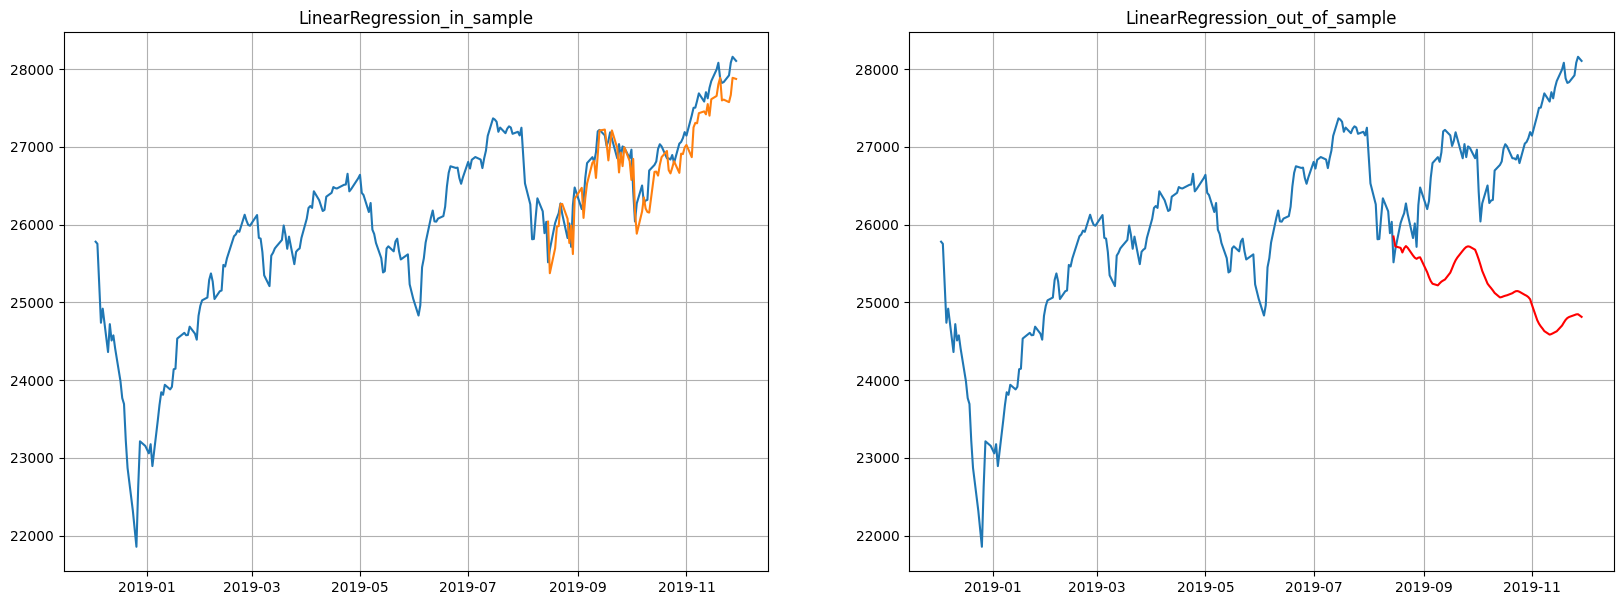

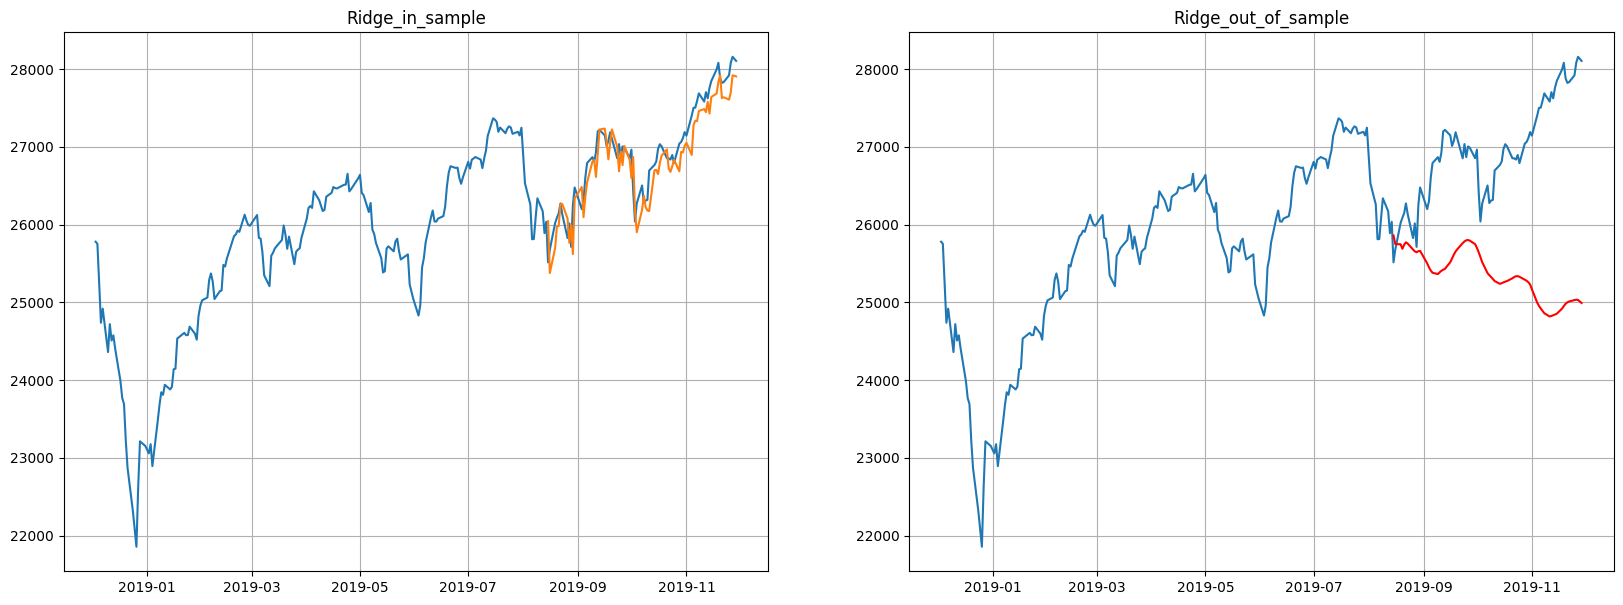

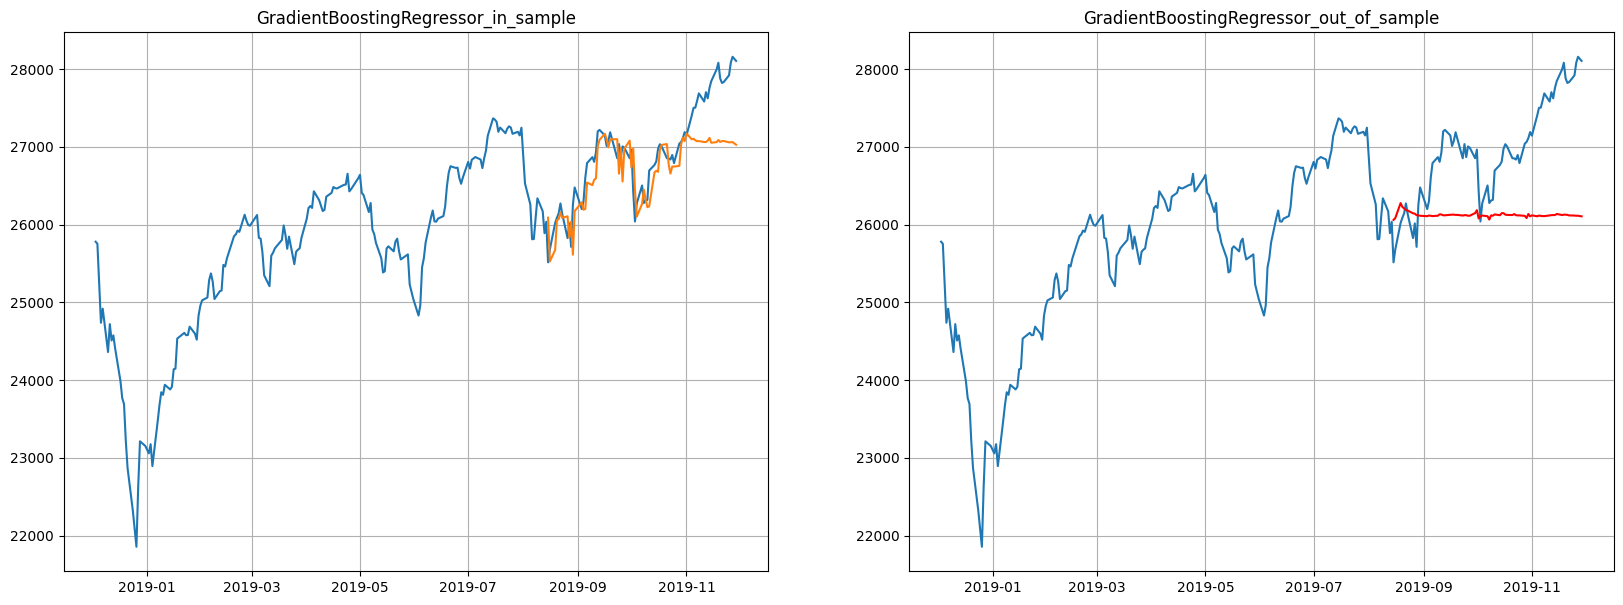

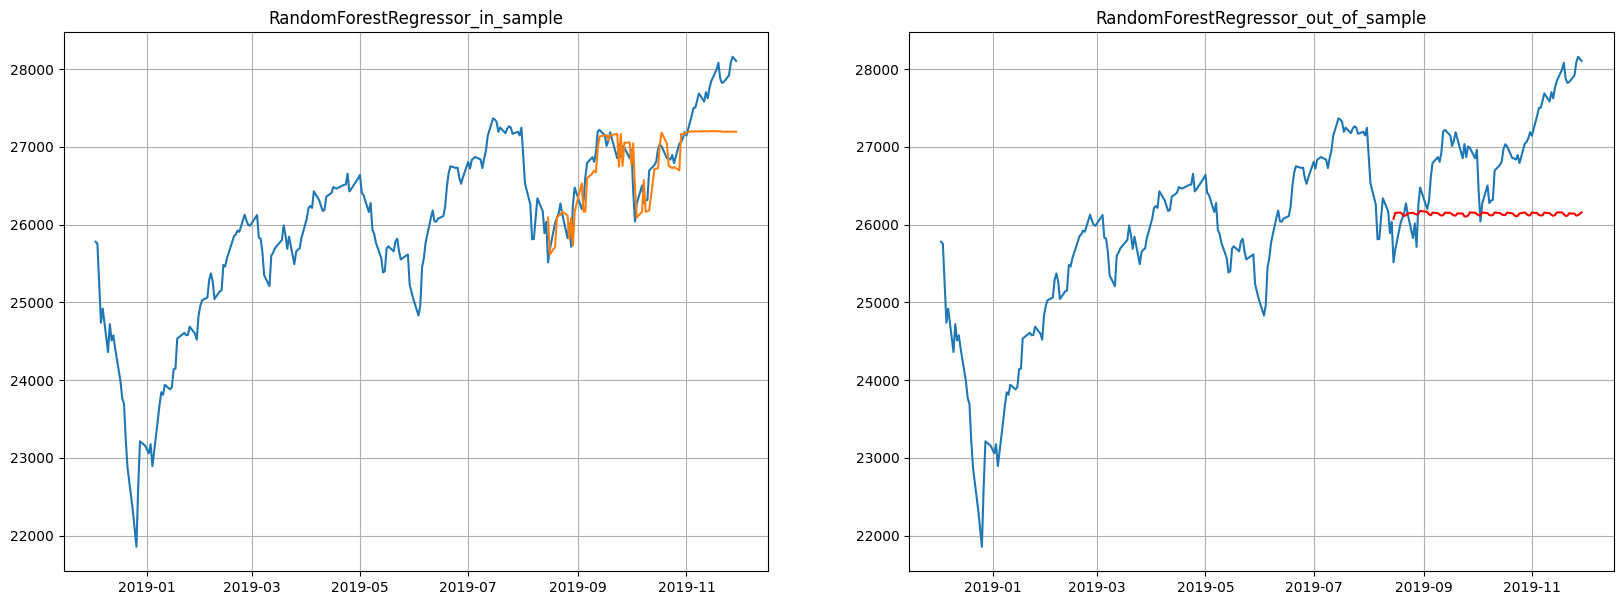

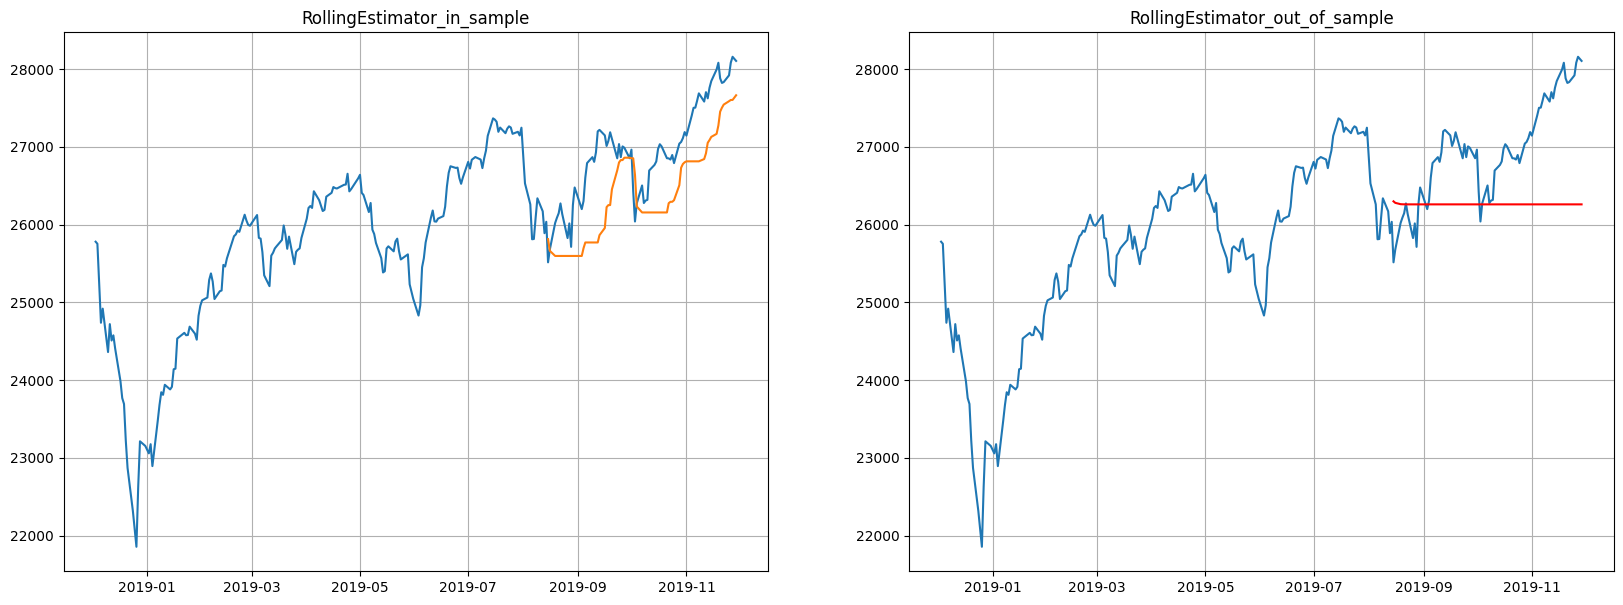

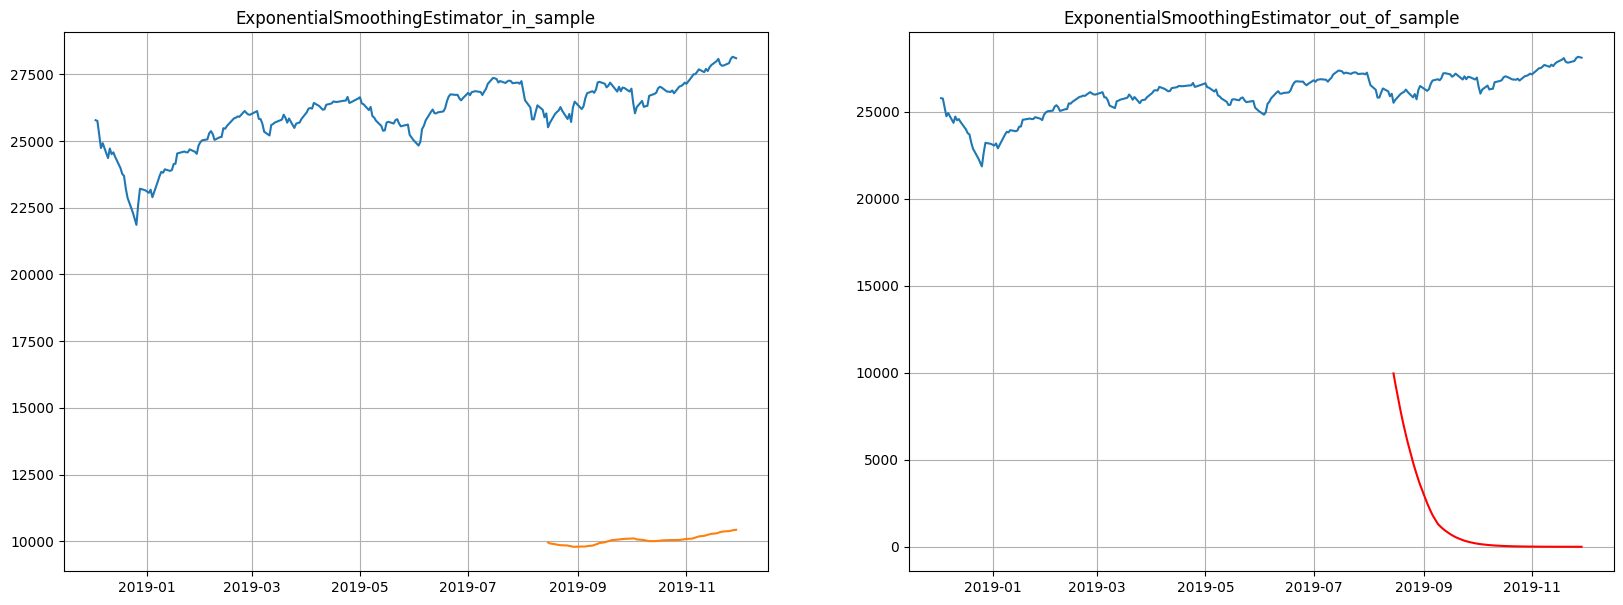

In [ ]:
rand = forecast_ts(random_walk,'random_walk', models, models_names, param)

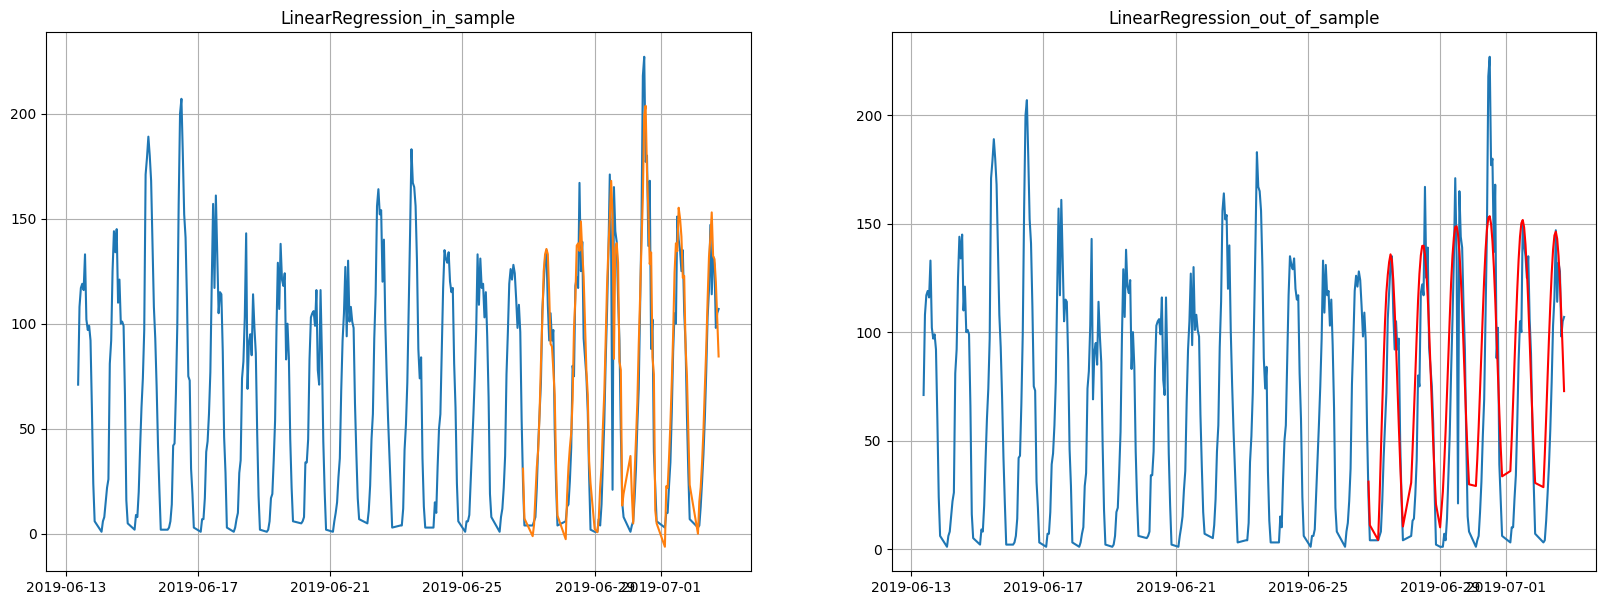

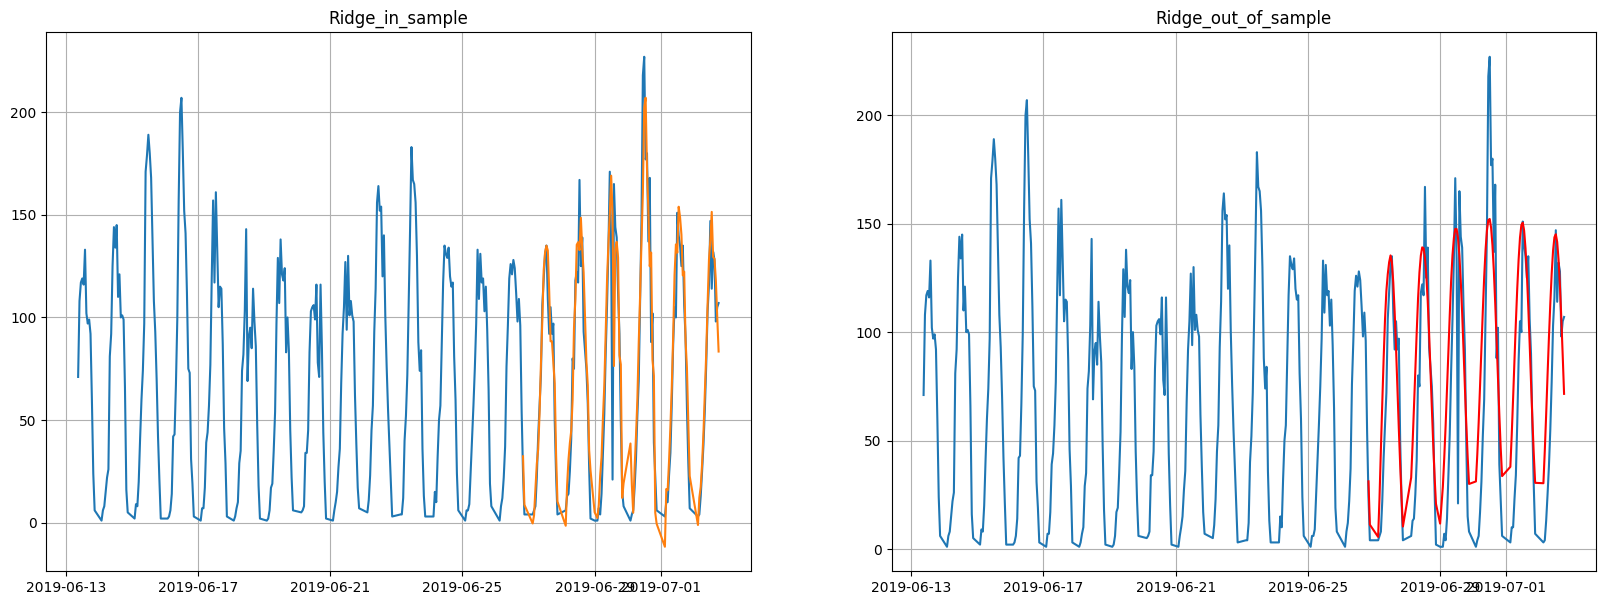

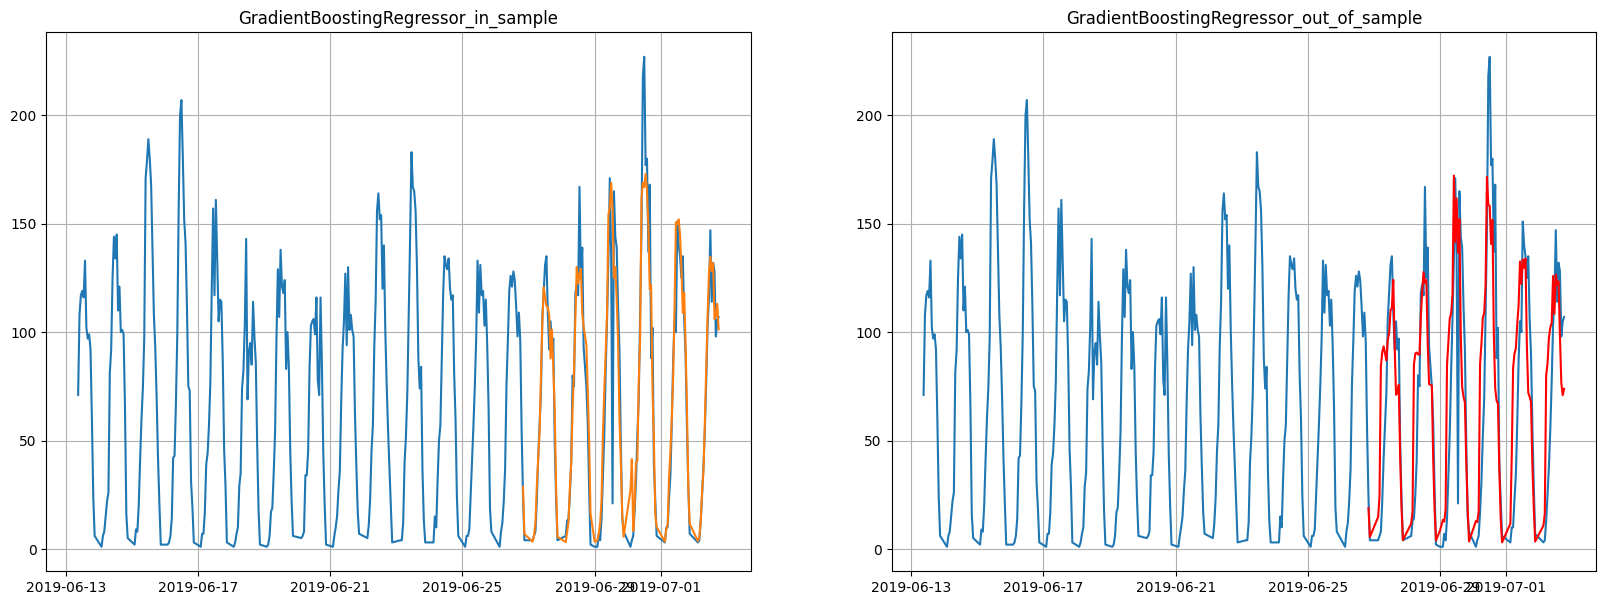

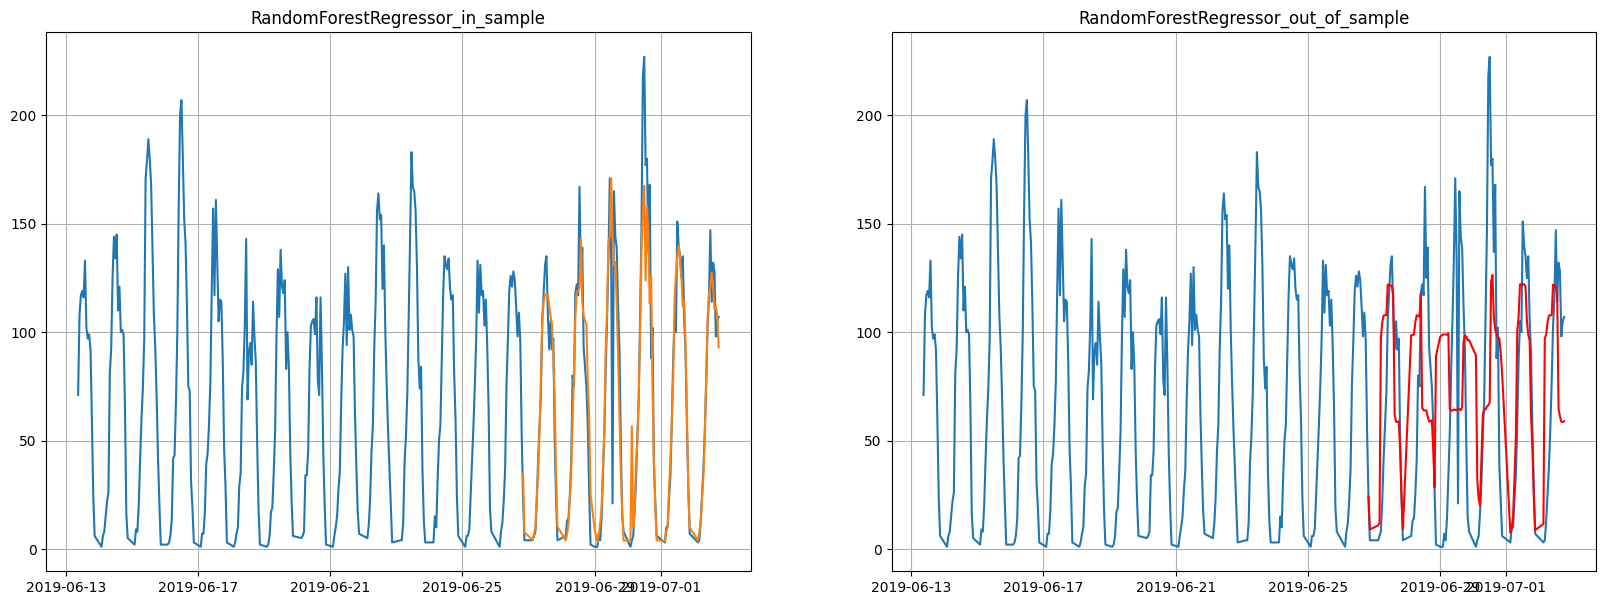

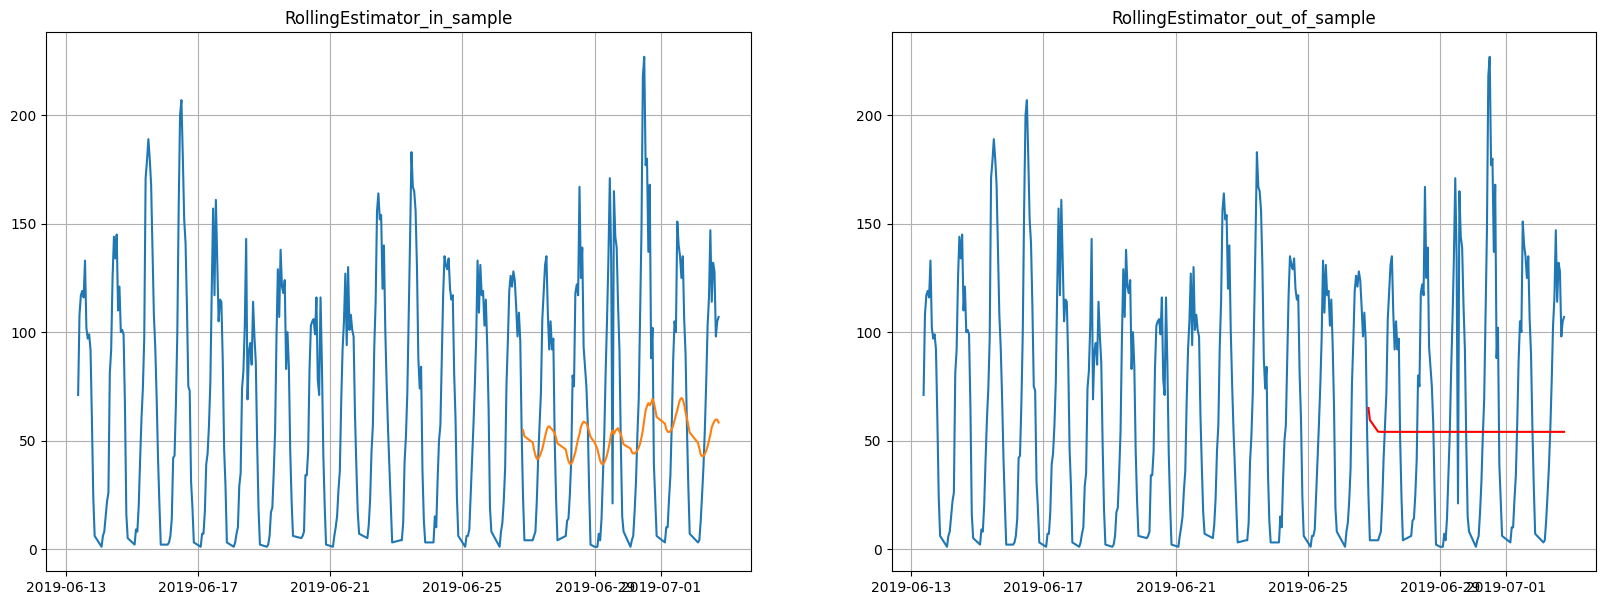

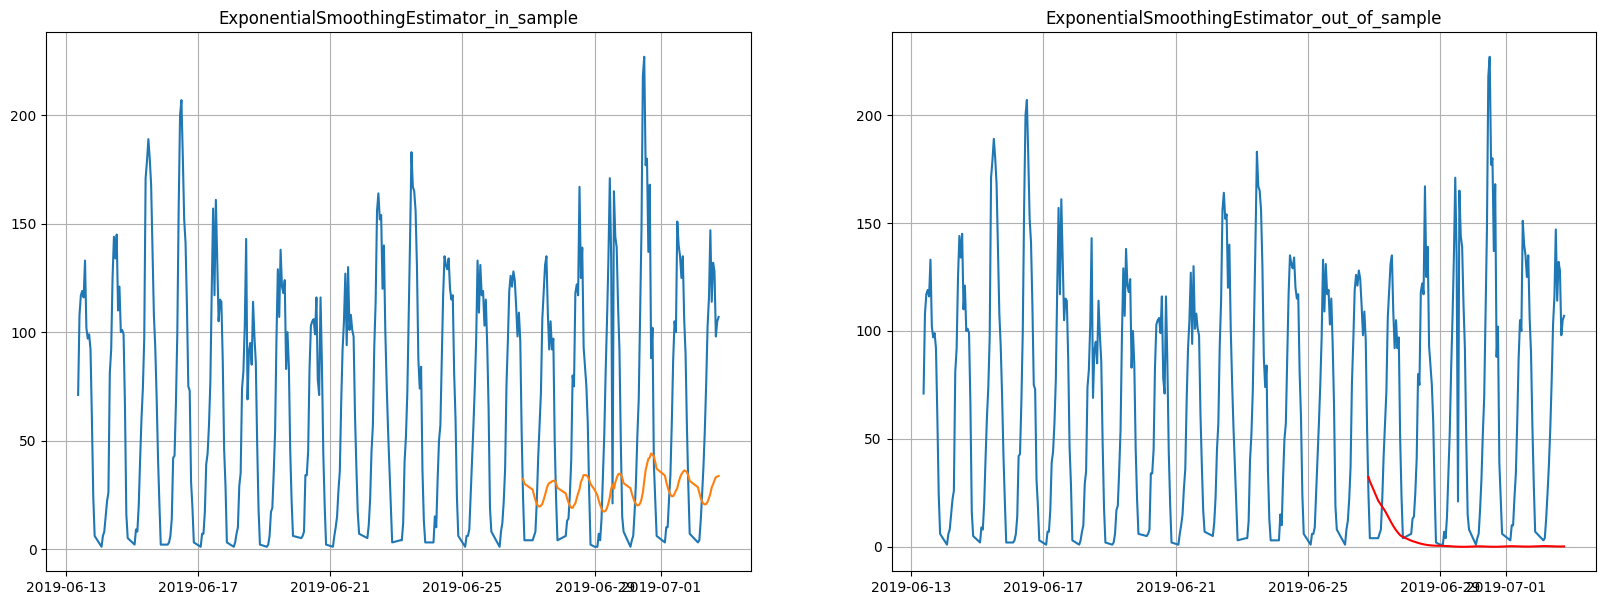

In [ ]:
short_df = forecast_ts(short_season,'short_season', models, models_names, param)

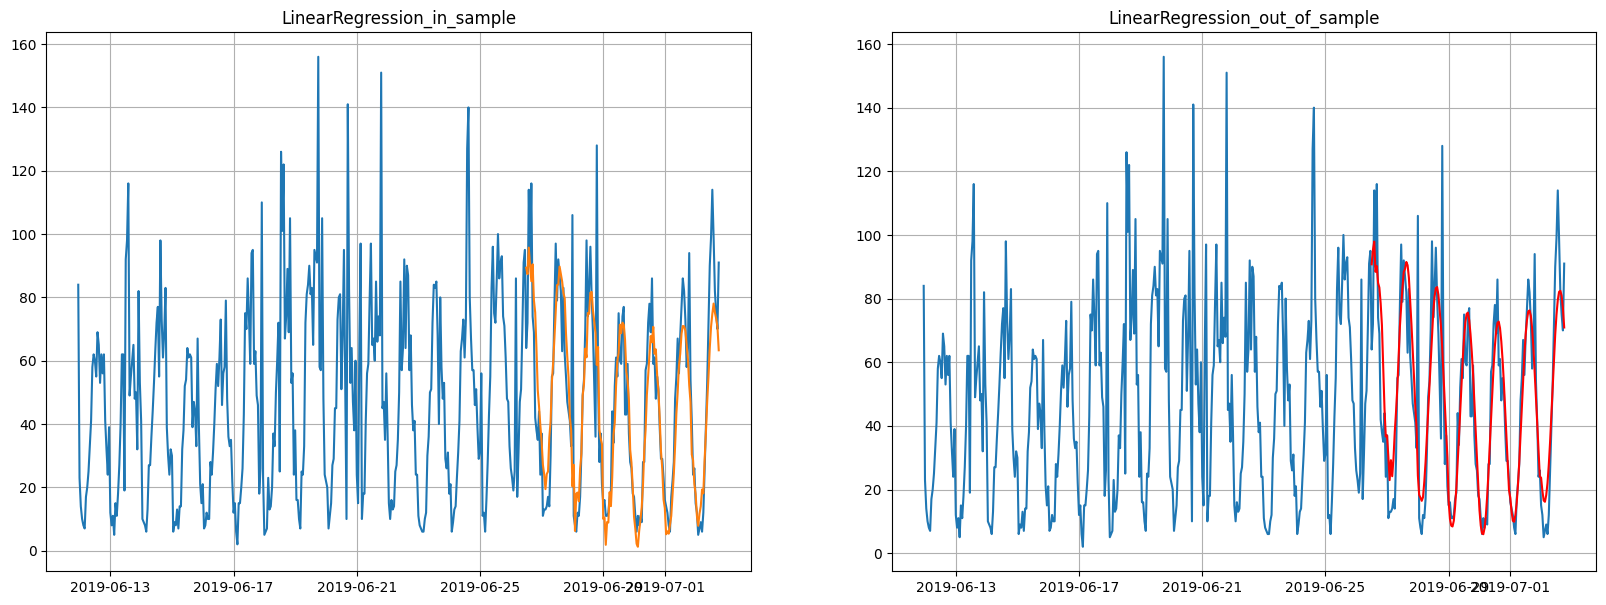

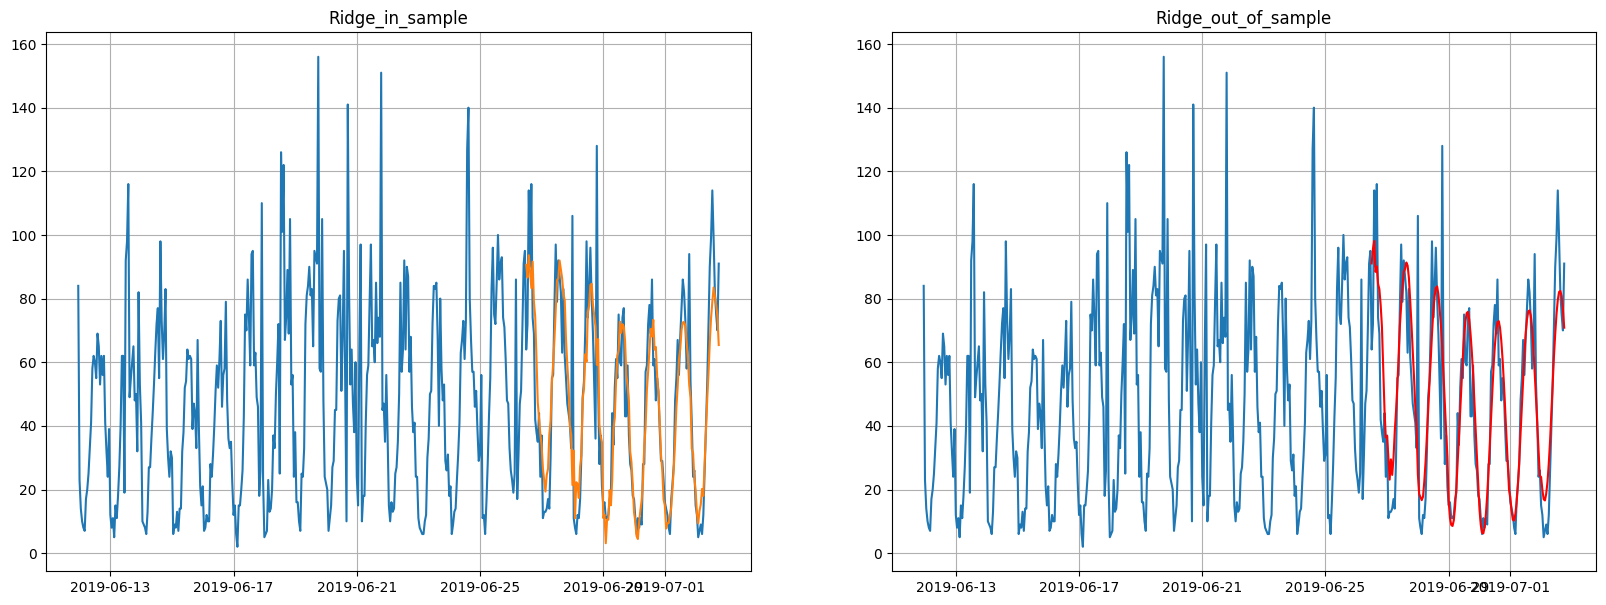

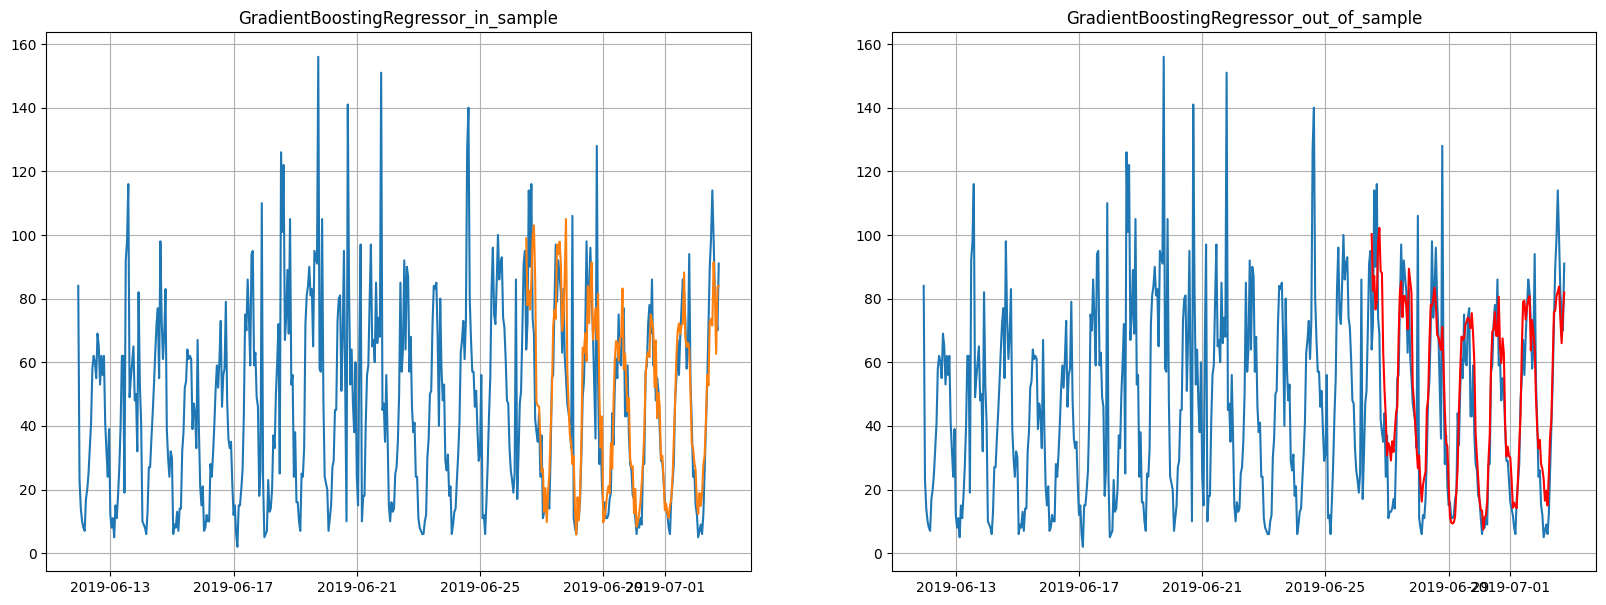

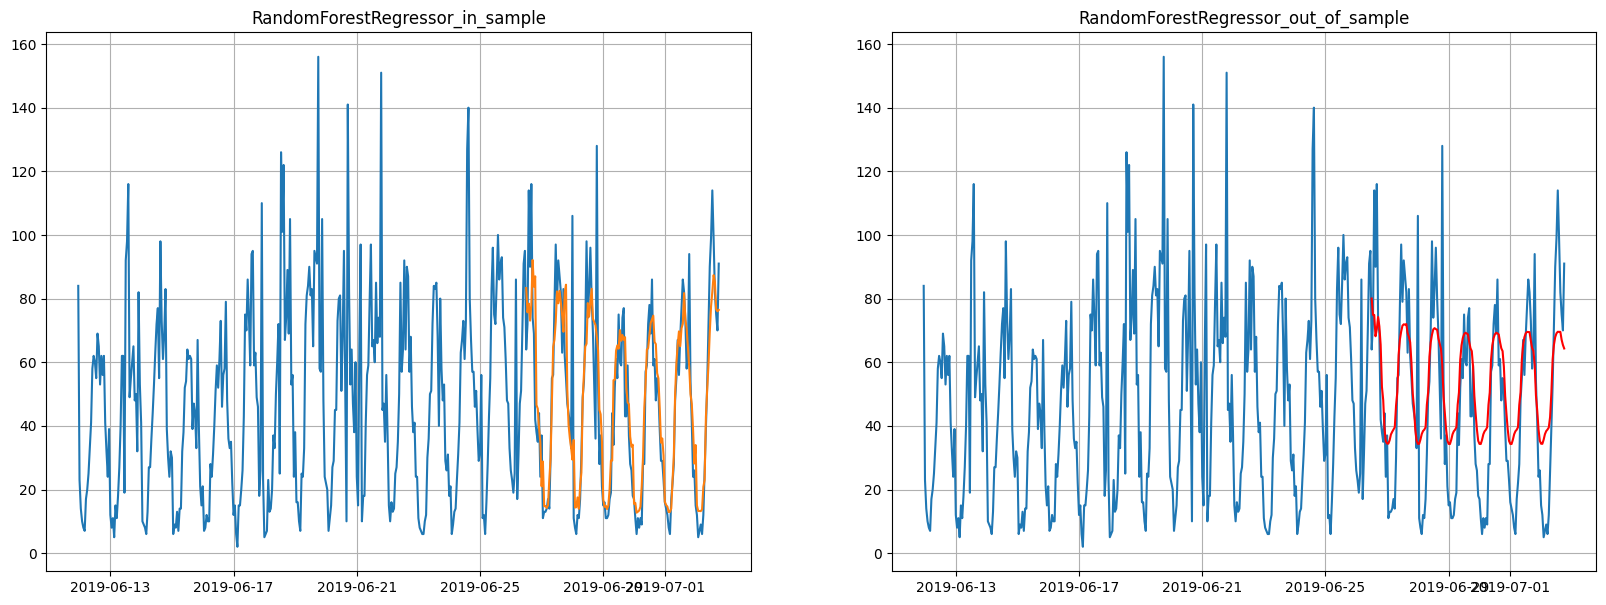

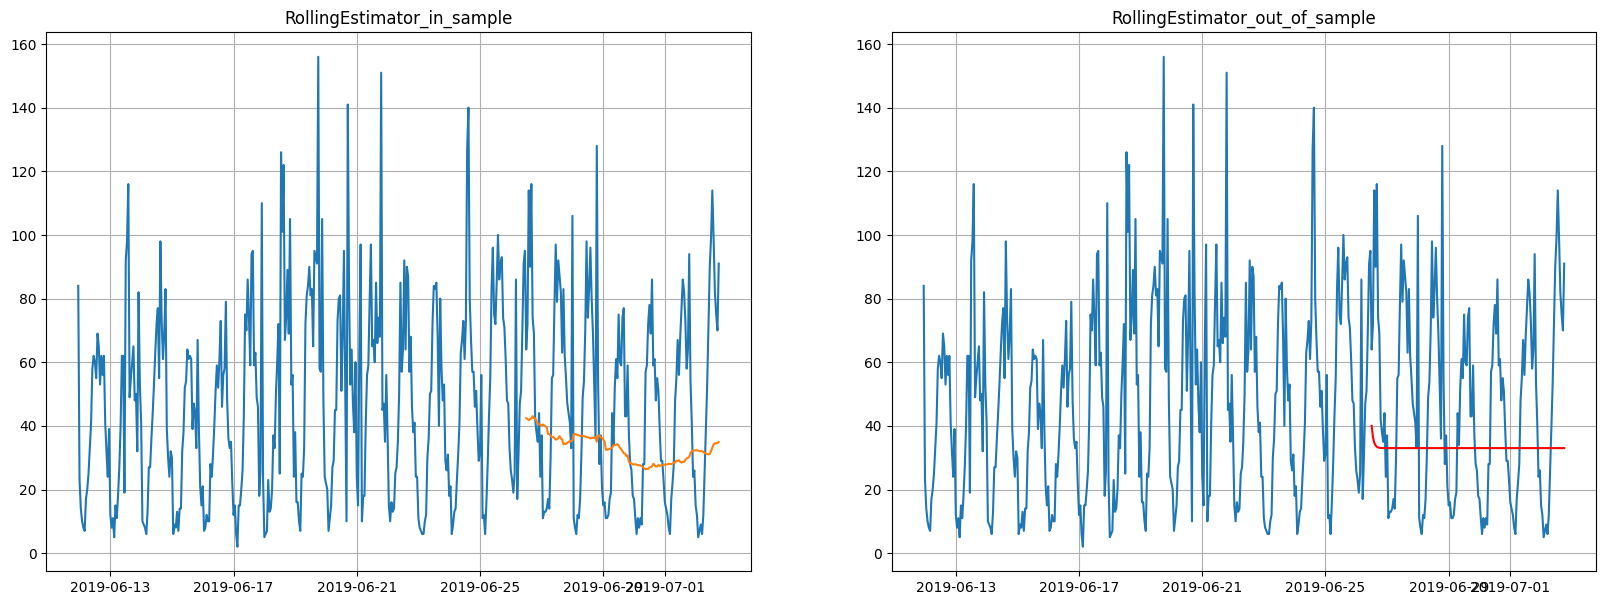

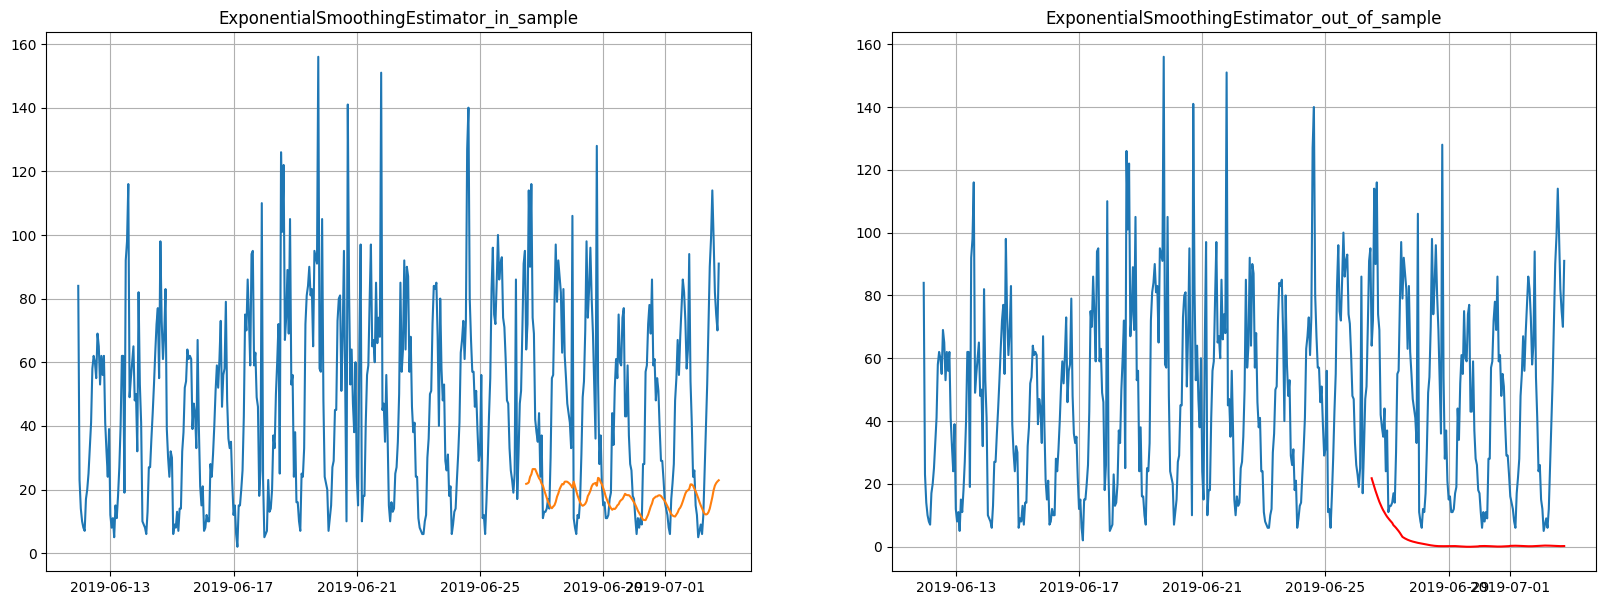

In [ ]:
medium = forecast_ts(medium_noize,'medium_noize', models, models_names, param)

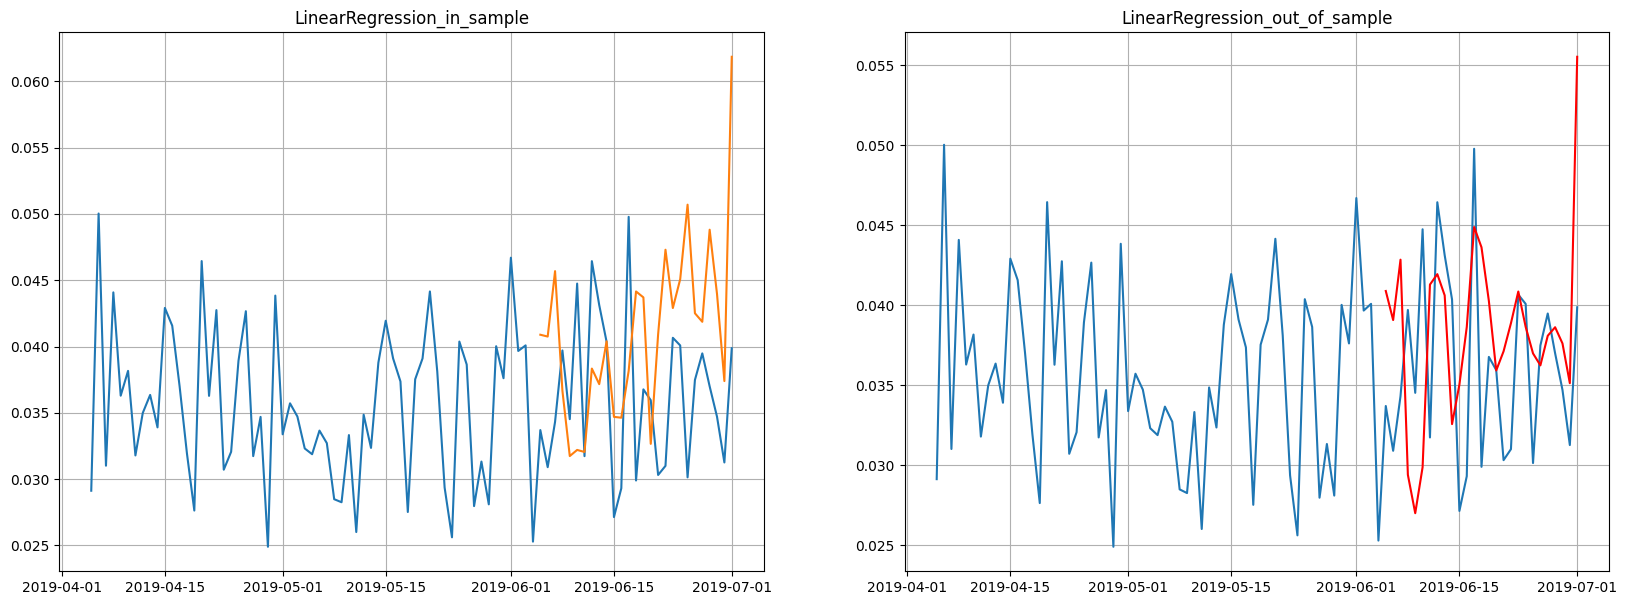

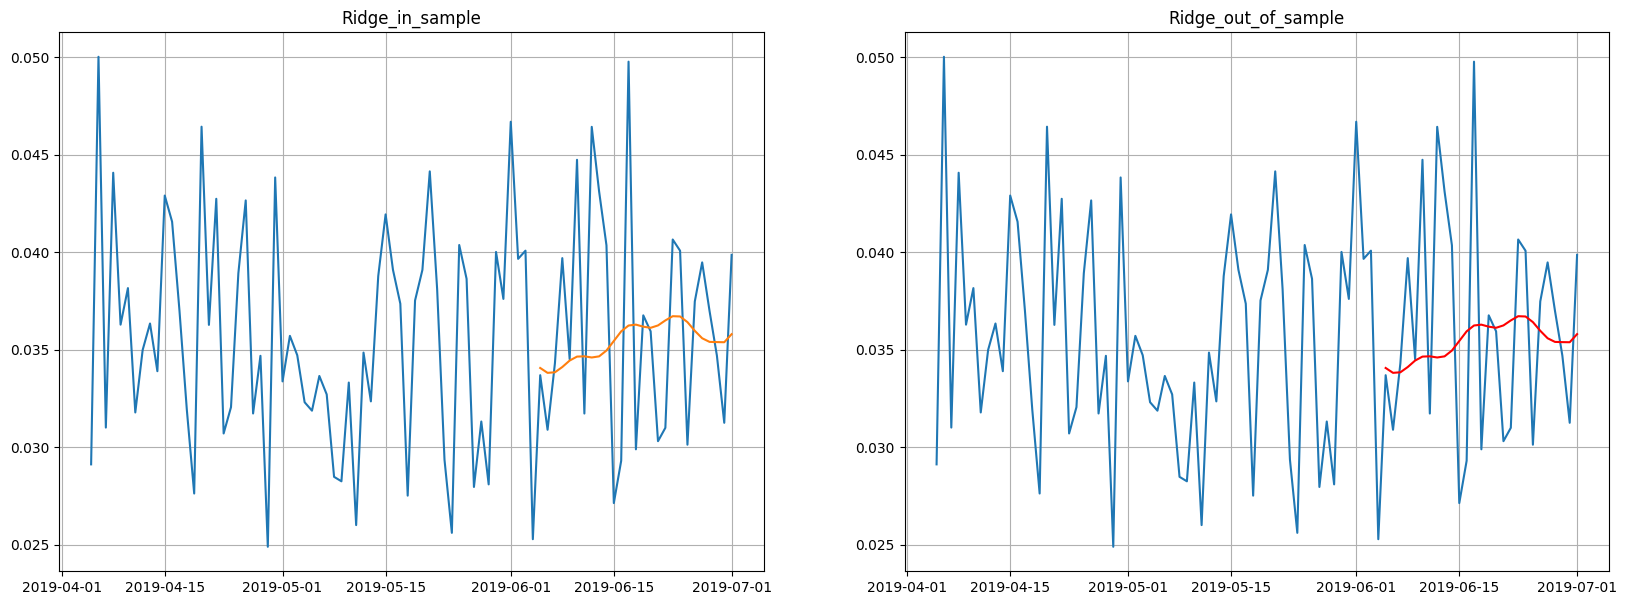

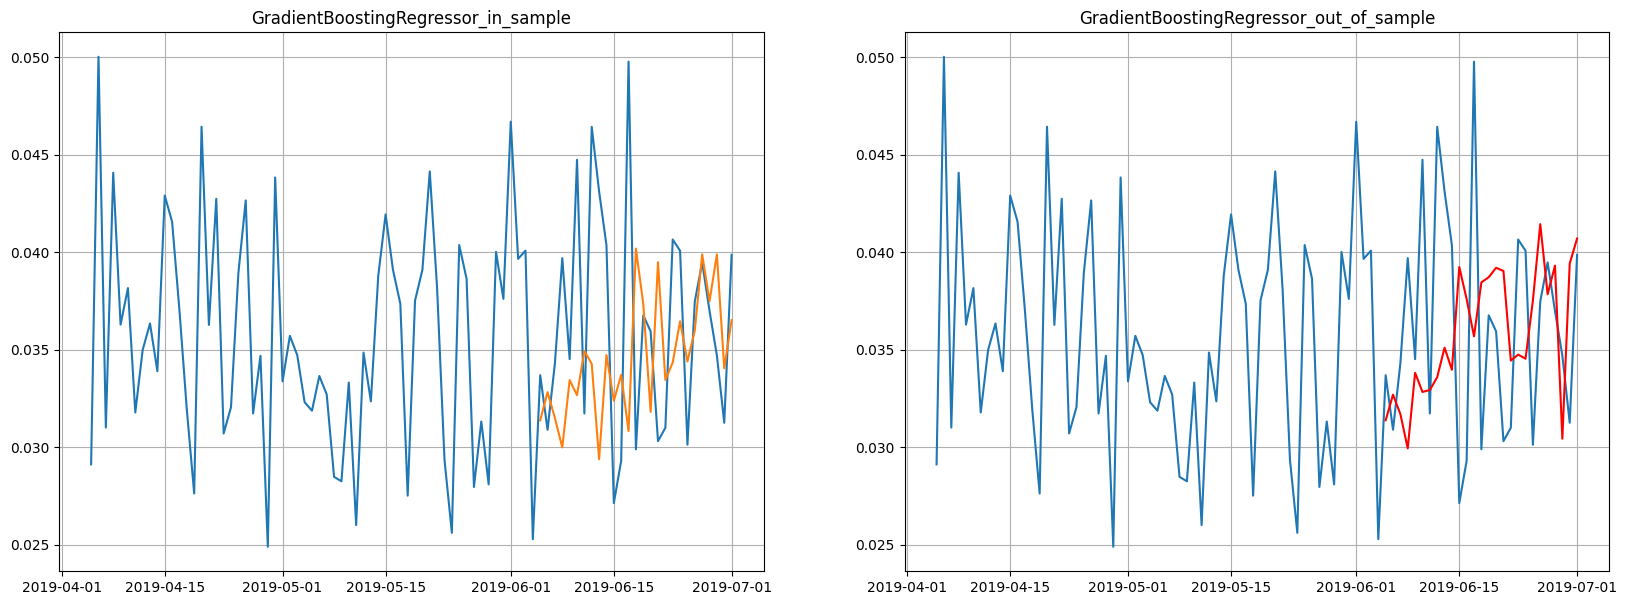

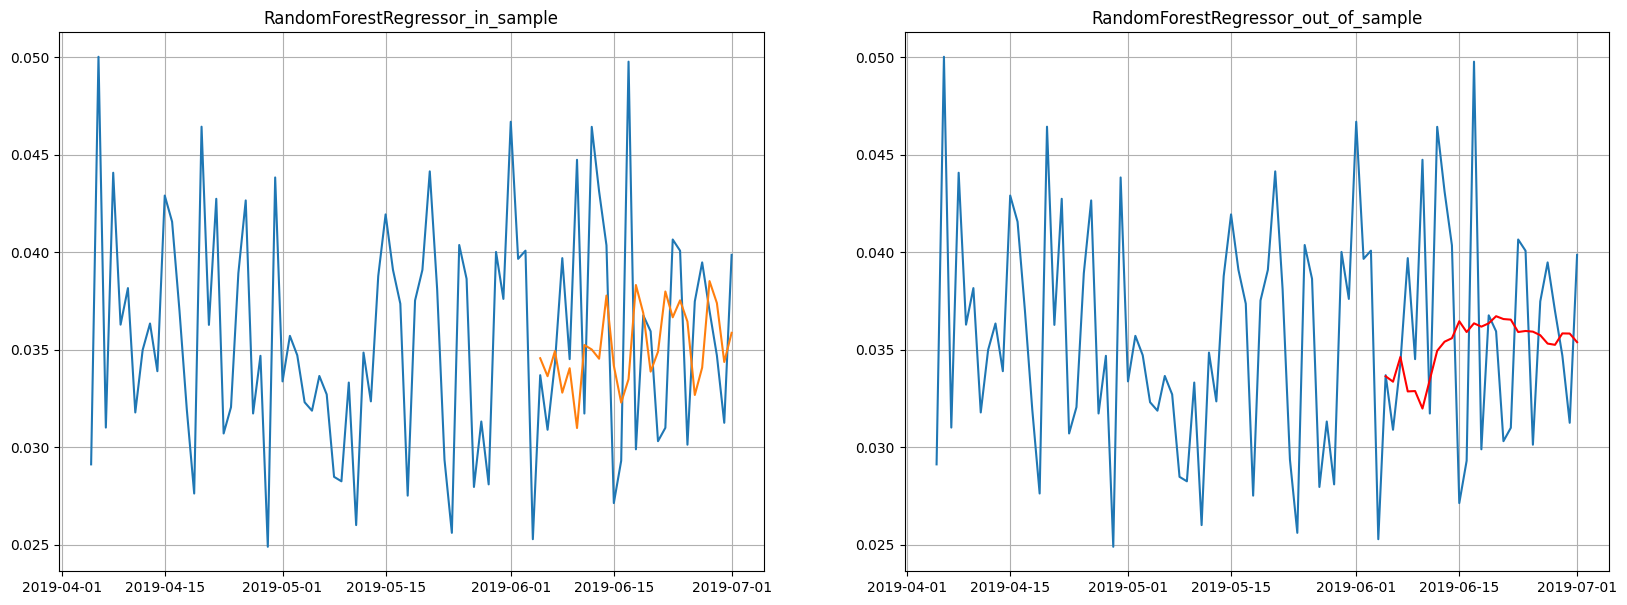

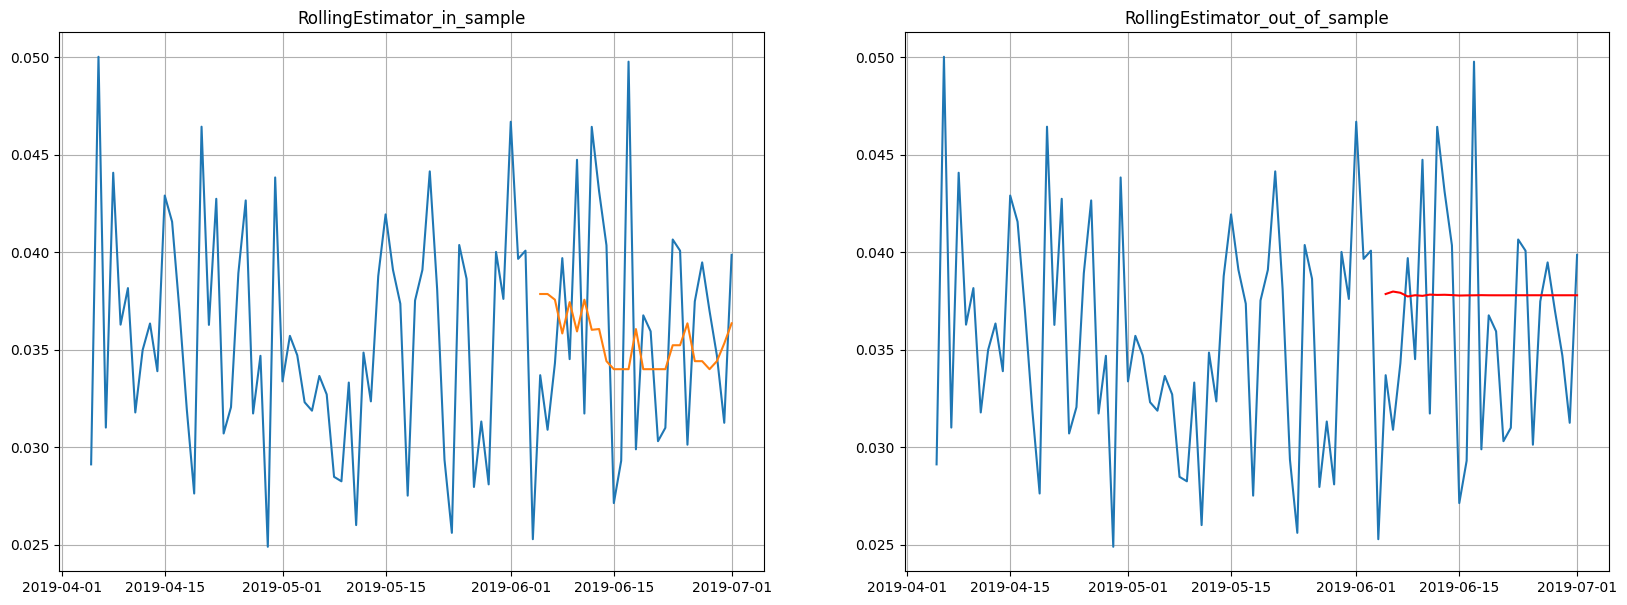

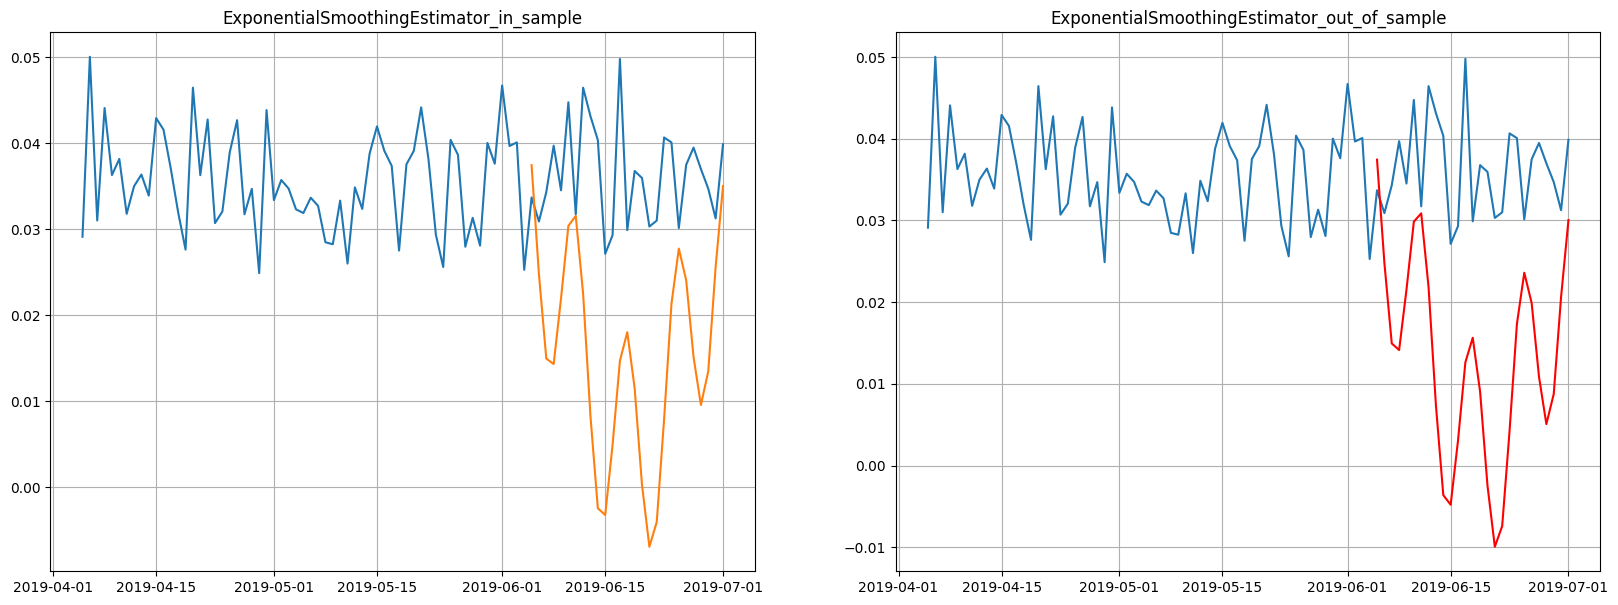

In [ ]:
full = forecast_ts(full_noize, 'full_noize', models, models_names, param)

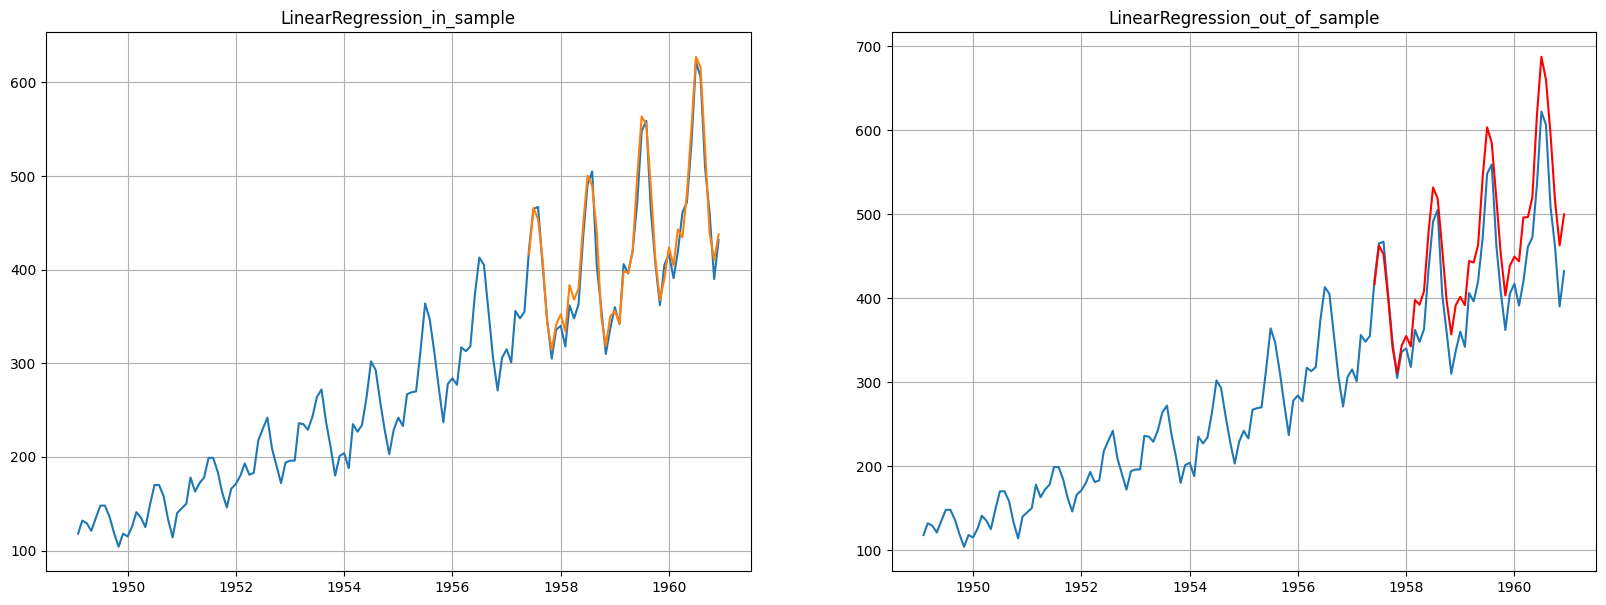

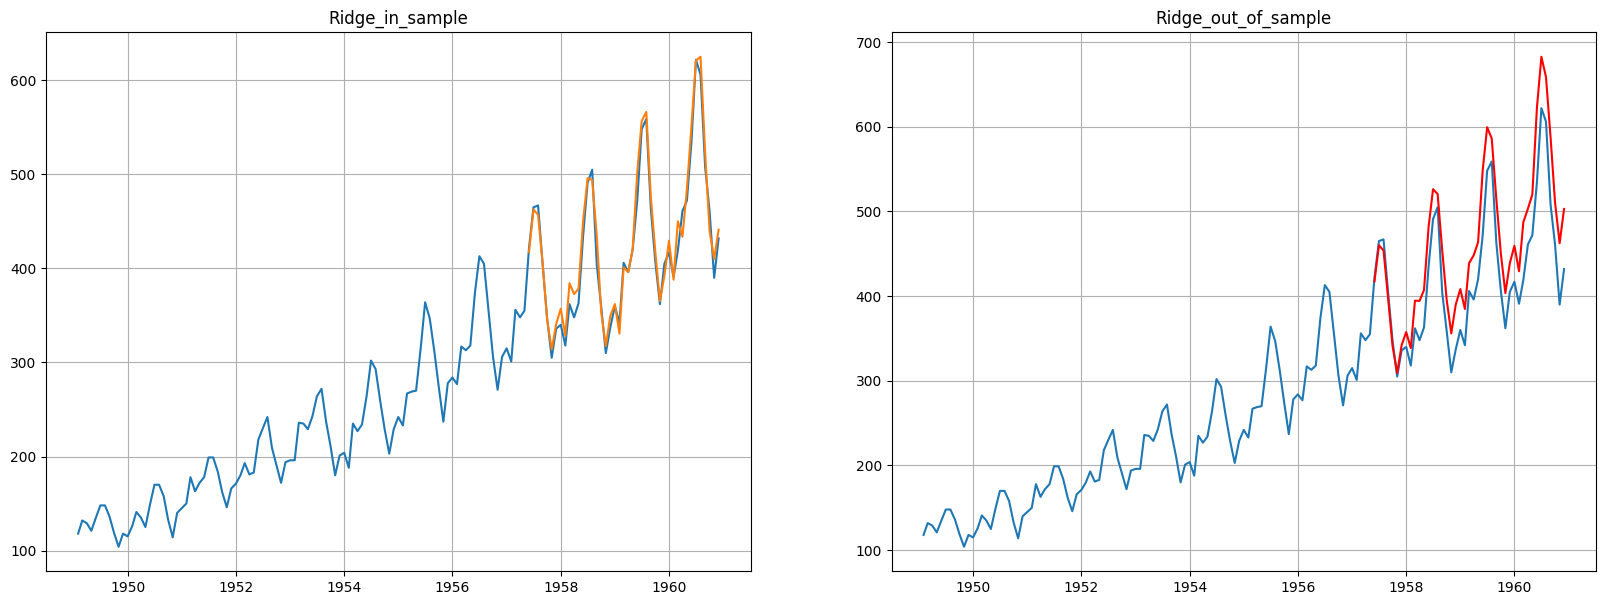

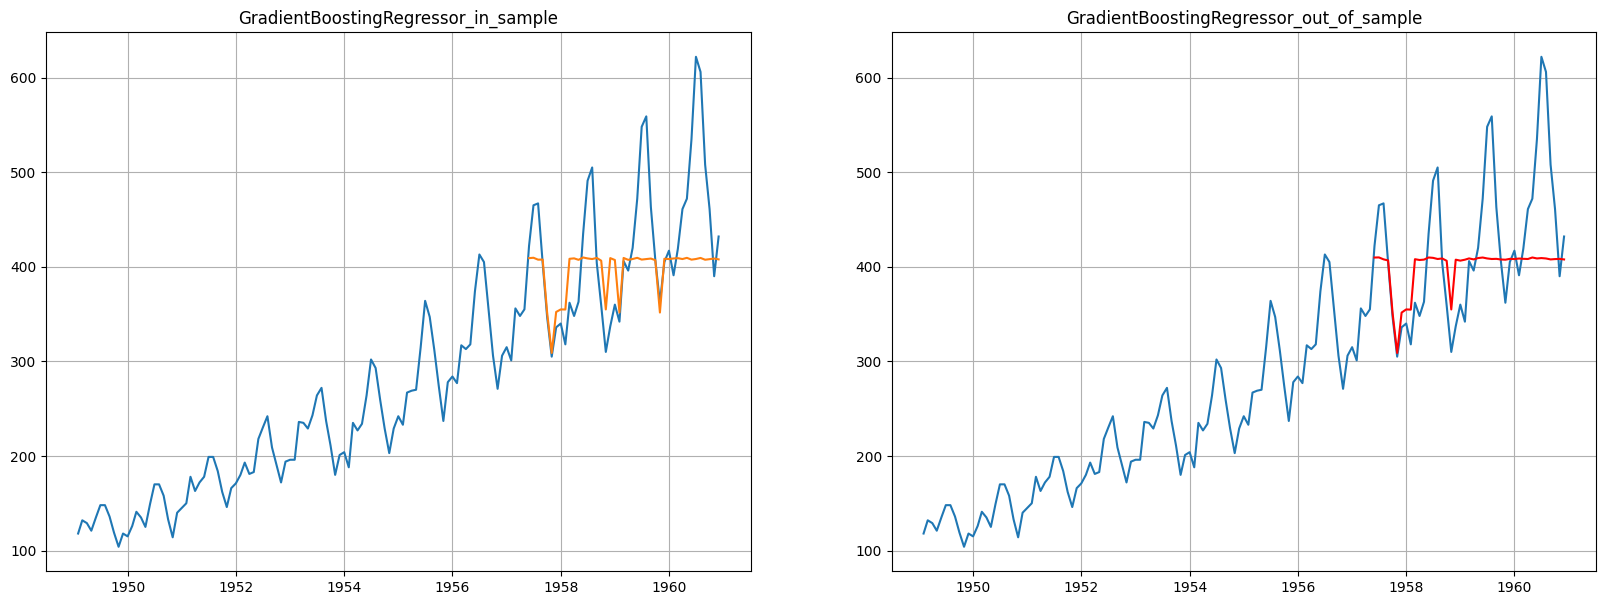

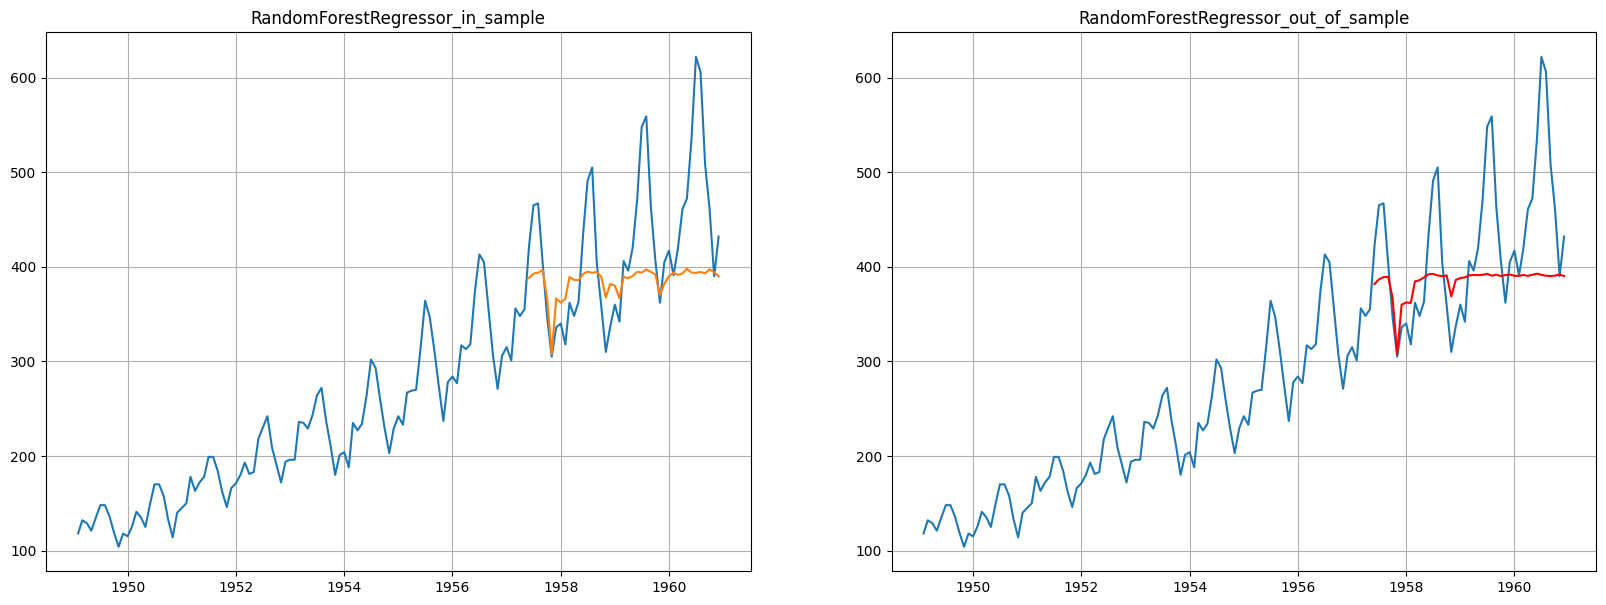

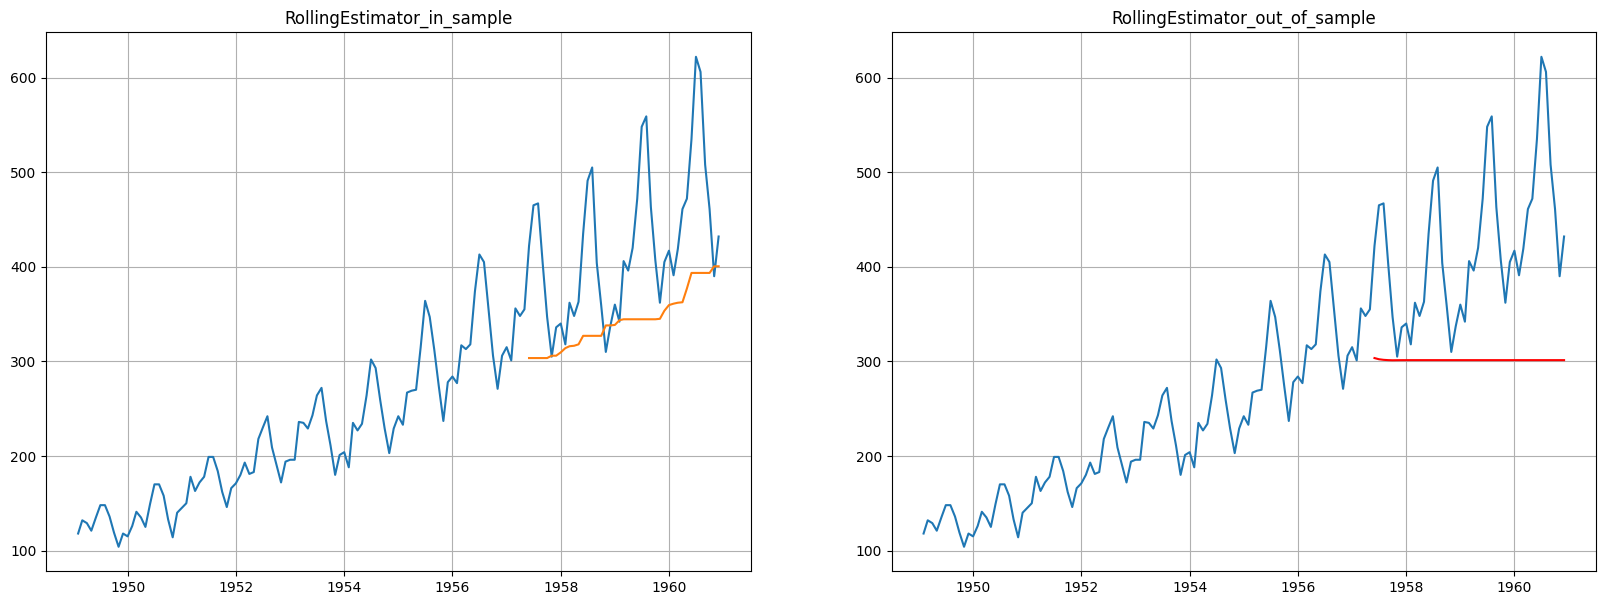

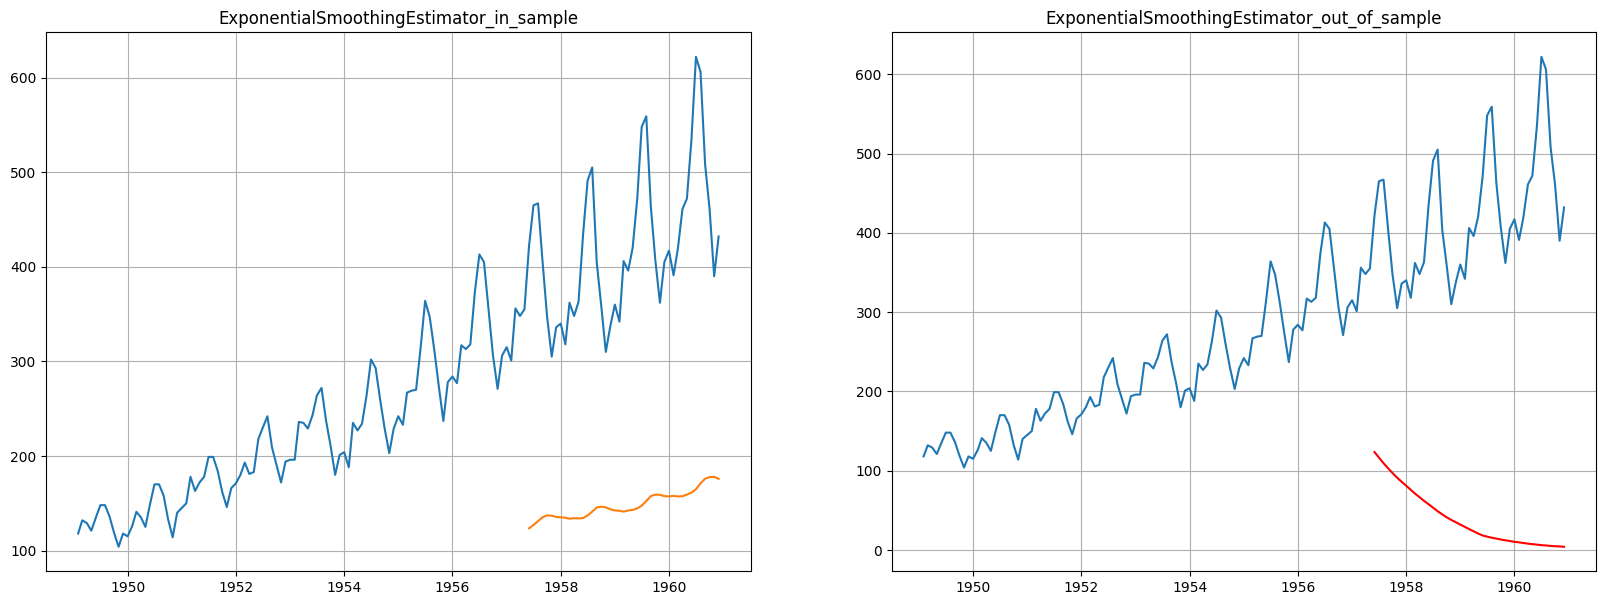

In [ ]:
sh_tr = forecast_ts(short_season_trend, 'short_season_trend', models, models_names, param)

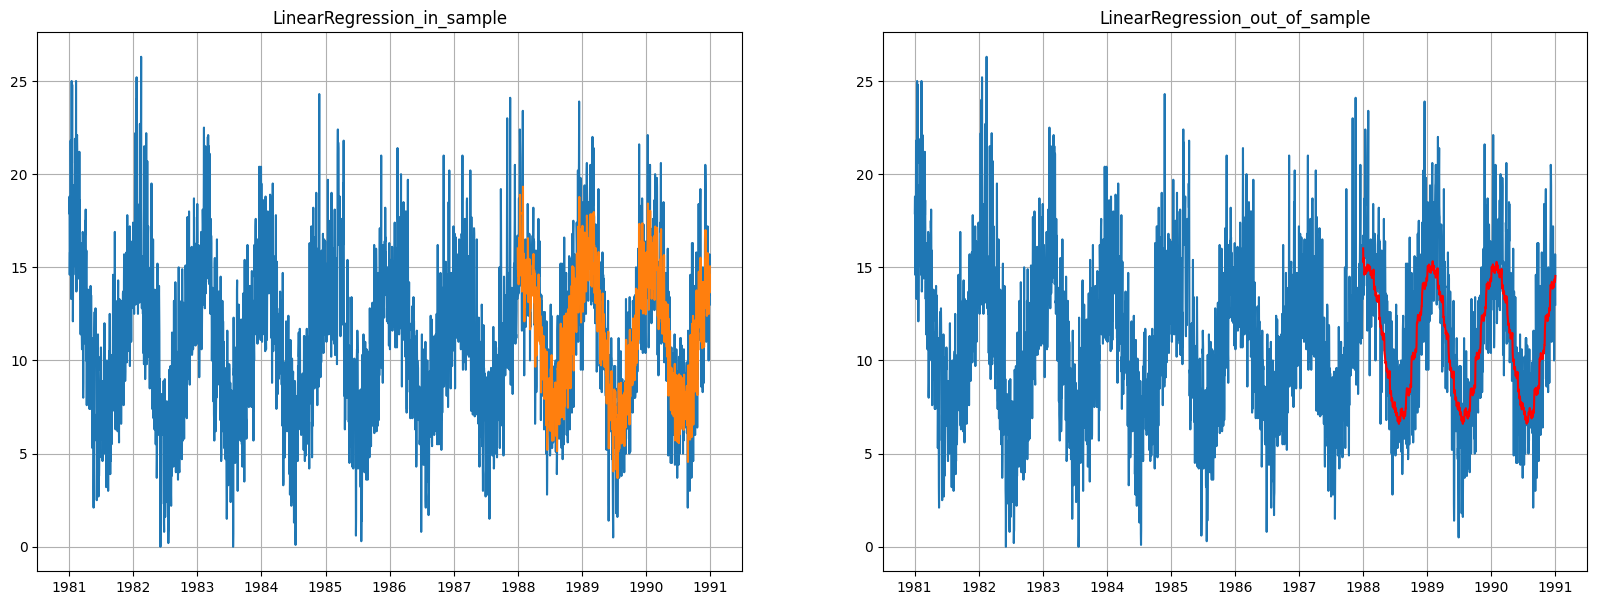

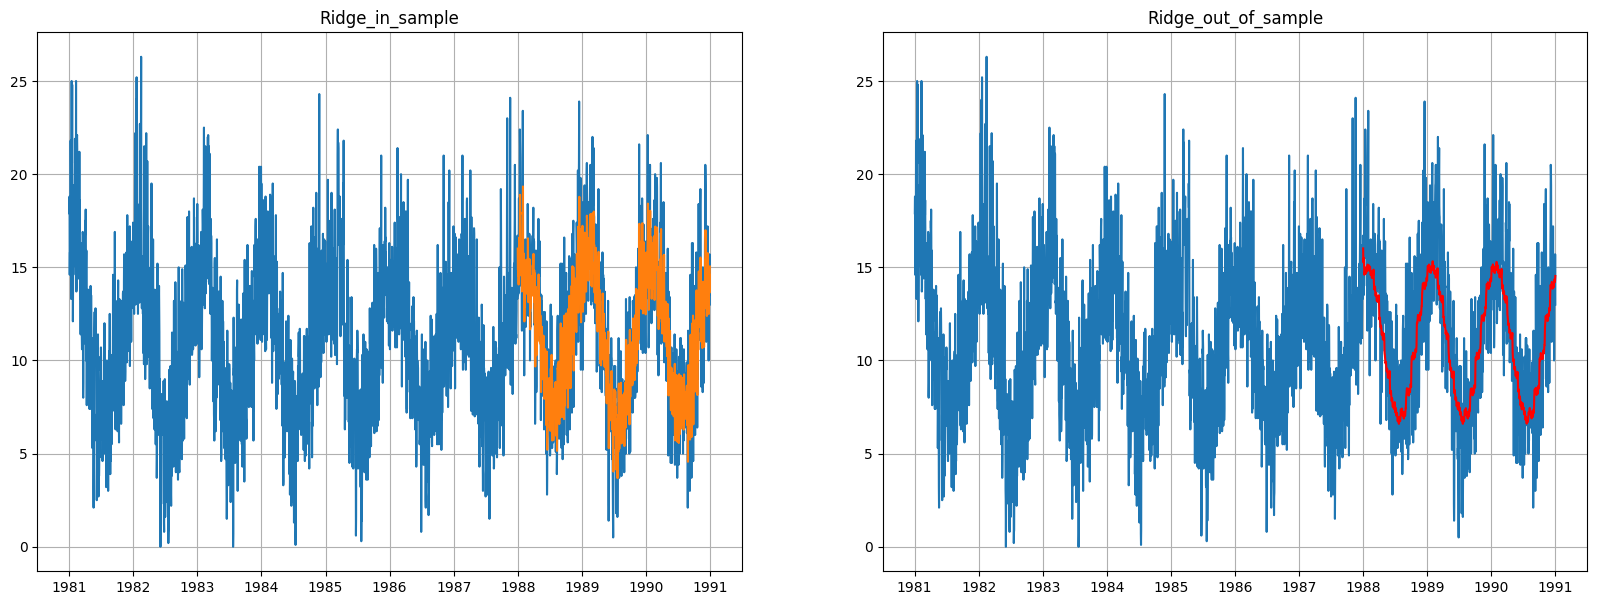

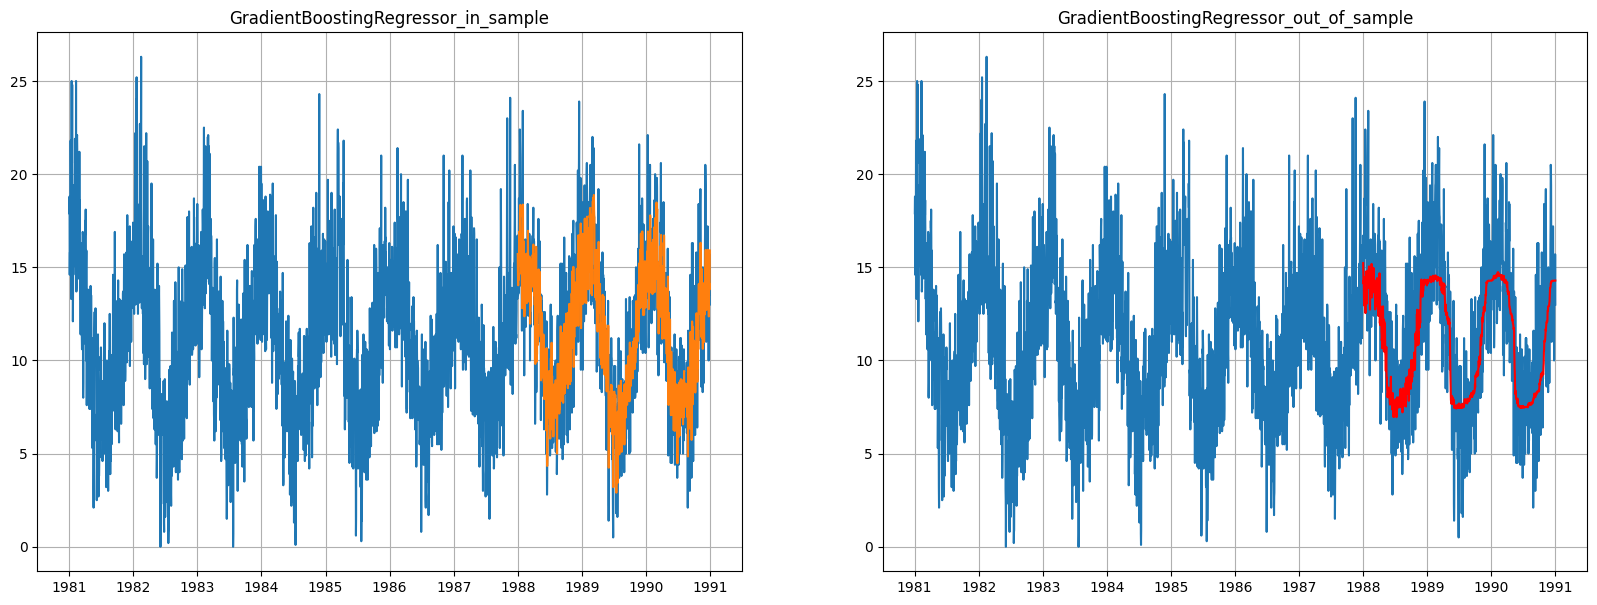

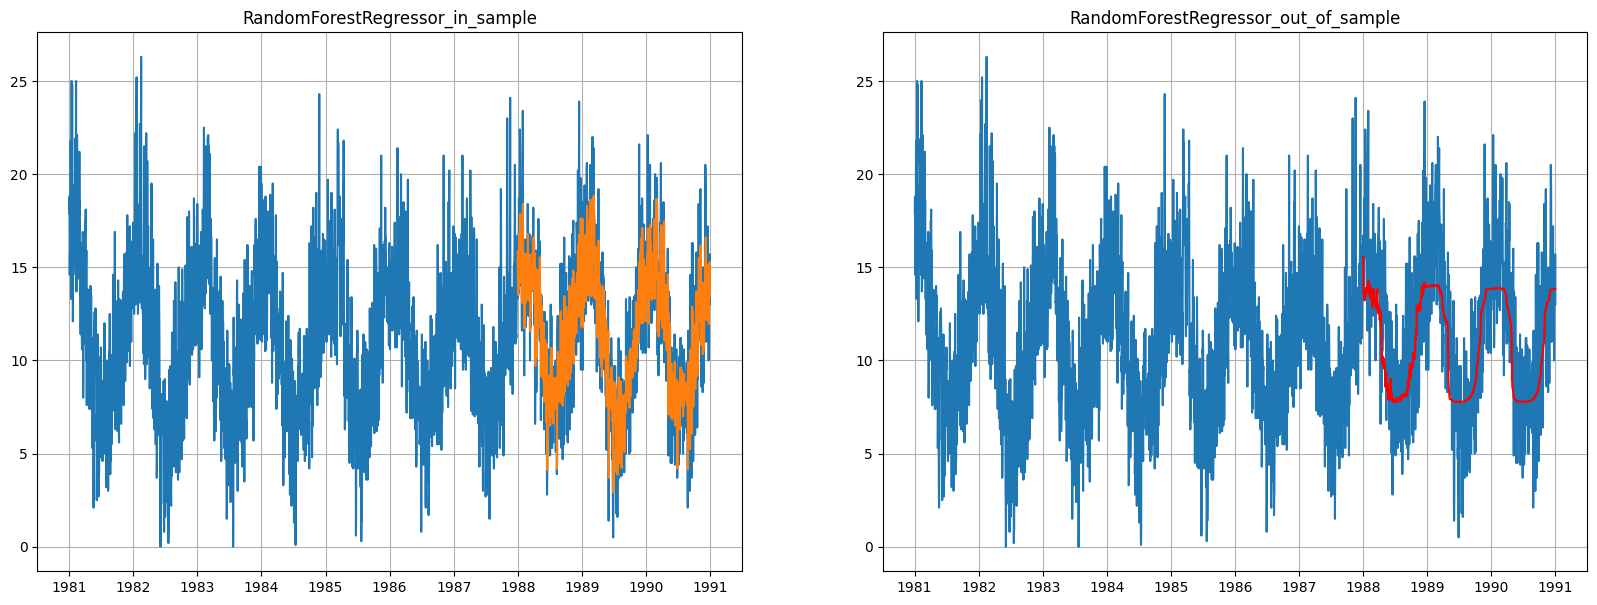

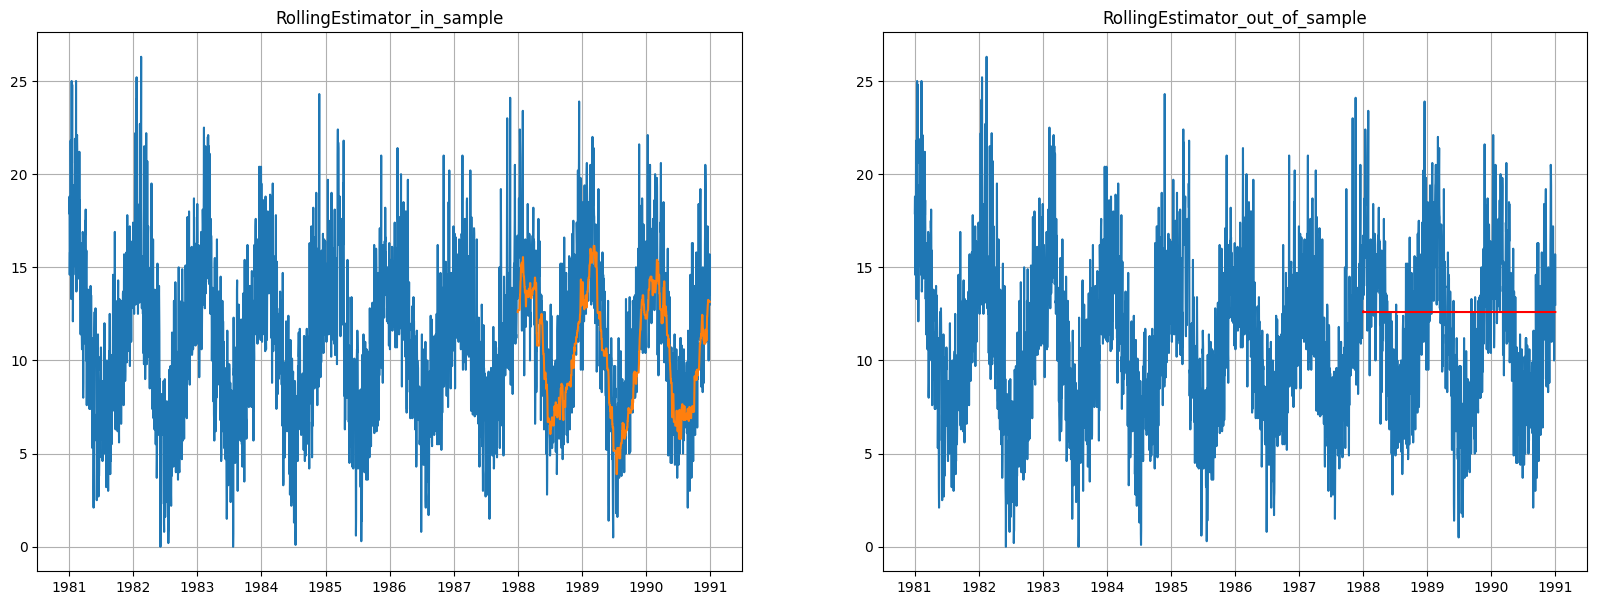

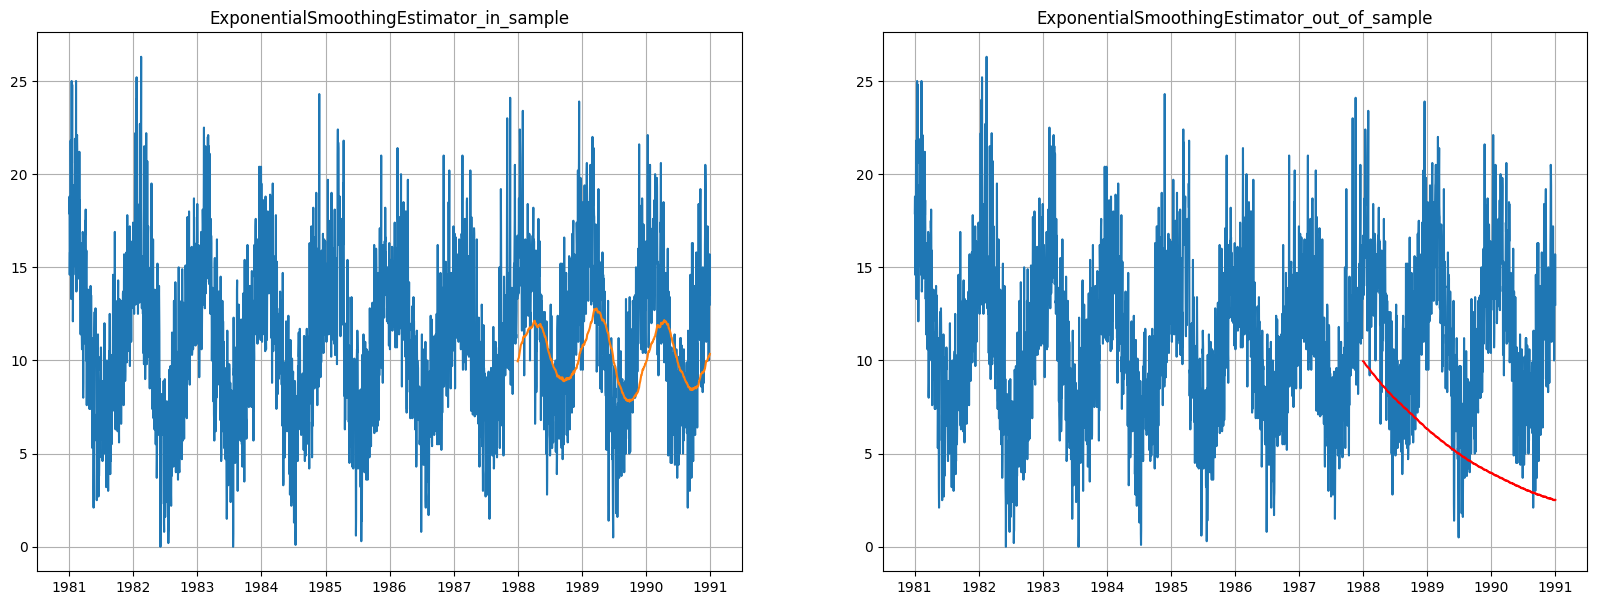

In [ ]:
param_long = [{'num_lags':[24,365]},
         {'alpha':[0.3,0,5,0.8],'num_lags':[24,365]},
         {'max_depth':[3,5],'n_estimators':[100,200],'num_lags':[24,365]},
        {'max_depth':[3,5],'n_estimators':[100,200],'num_lags':[24,365]},
         {'num_lags':[24,365], 'rolling_filter':['mean', 'median']},
         {'num_lags':[24,365], 'alpha_coef':[0.01,0.08,1]}]

long_df = forecast_ts(long, 'long', models, models_names, param_long)

2019-06-26 20:00:00 2019-07-02 18:00:00
2019-06-26 20:00:00 2019-07-02 18:00:00
2019-06-26 20:00:00 2019-07-02 18:00:00
2019-06-26 20:00:00 2019-07-02 18:00:00
2019-06-26 20:00:00 2019-07-02 18:00:00
2019-06-26 20:00:00 2019-07-02 18:00:00


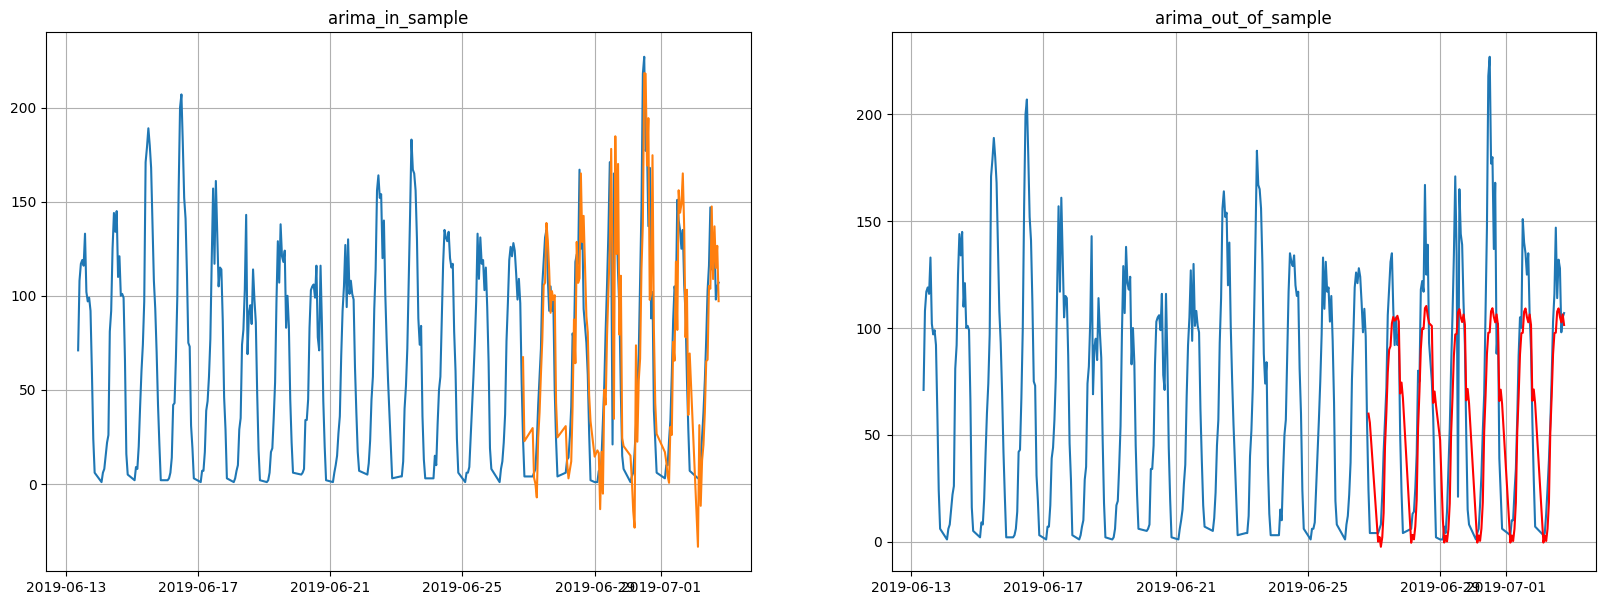

In [ ]:
param_ar= {'period':[12,24], 'd':[0,1]}
arima_short = forecast_ts_arima(short_season,'short_season','arima', param_grid = param_ar)

1957-06-01 00:00:00 1960-12-01 00:00:00
1957-06-01 00:00:00 1960-12-01 00:00:00
1957-06-01 00:00:00 1960-12-01 00:00:00
1957-06-01 00:00:00 1960-12-01 00:00:00
1957-06-01 00:00:00 1960-12-01 00:00:00
1957-06-01 00:00:00 1960-12-01 00:00:00


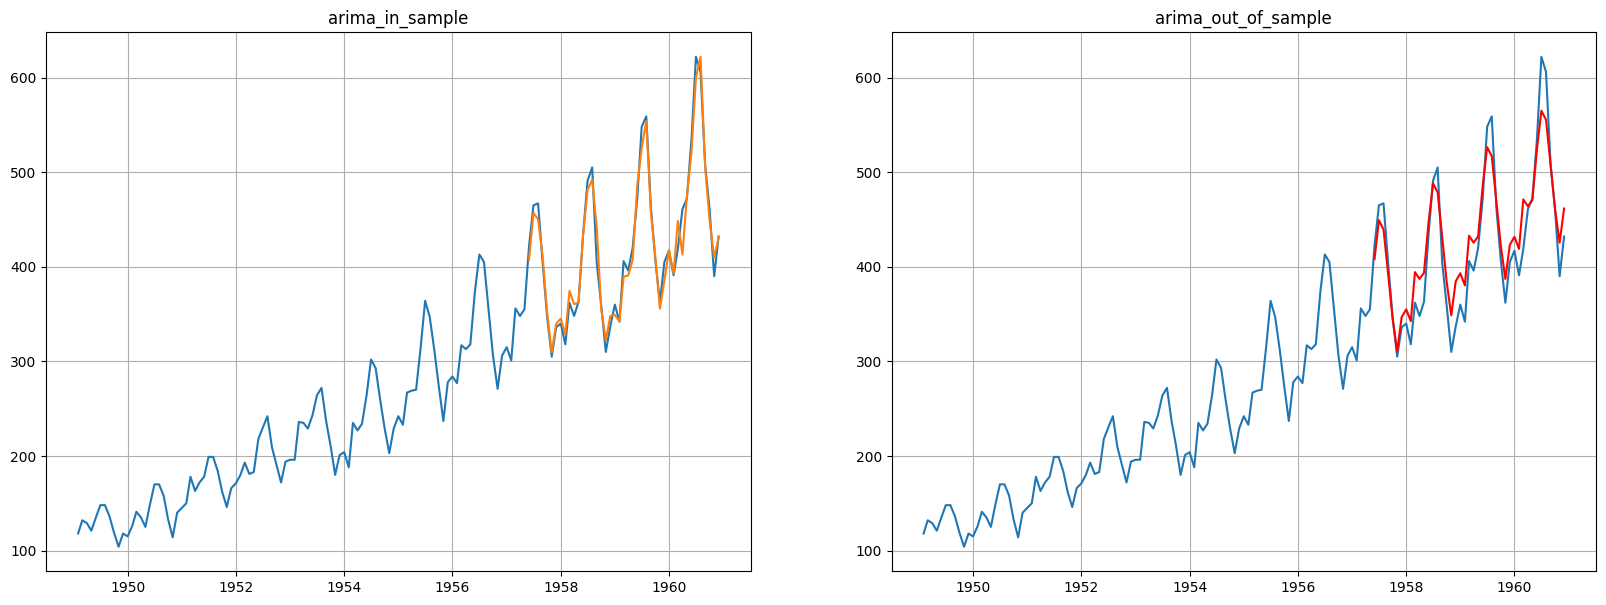

In [ ]:
arima_s_tr = forecast_ts_arima(short_season_trend,'short_season_trend','arima', param_grid = param_ar)

2019-06-05 00:00:00 2019-07-01 00:00:00
2019-06-05 00:00:00 2019-07-01 00:00:00
2019-06-05 00:00:00 2019-07-01 00:00:00
2019-06-05 00:00:00 2019-07-01 00:00:00
2019-06-05 00:00:00 2019-07-01 00:00:00
2019-06-05 00:00:00 2019-07-01 00:00:00


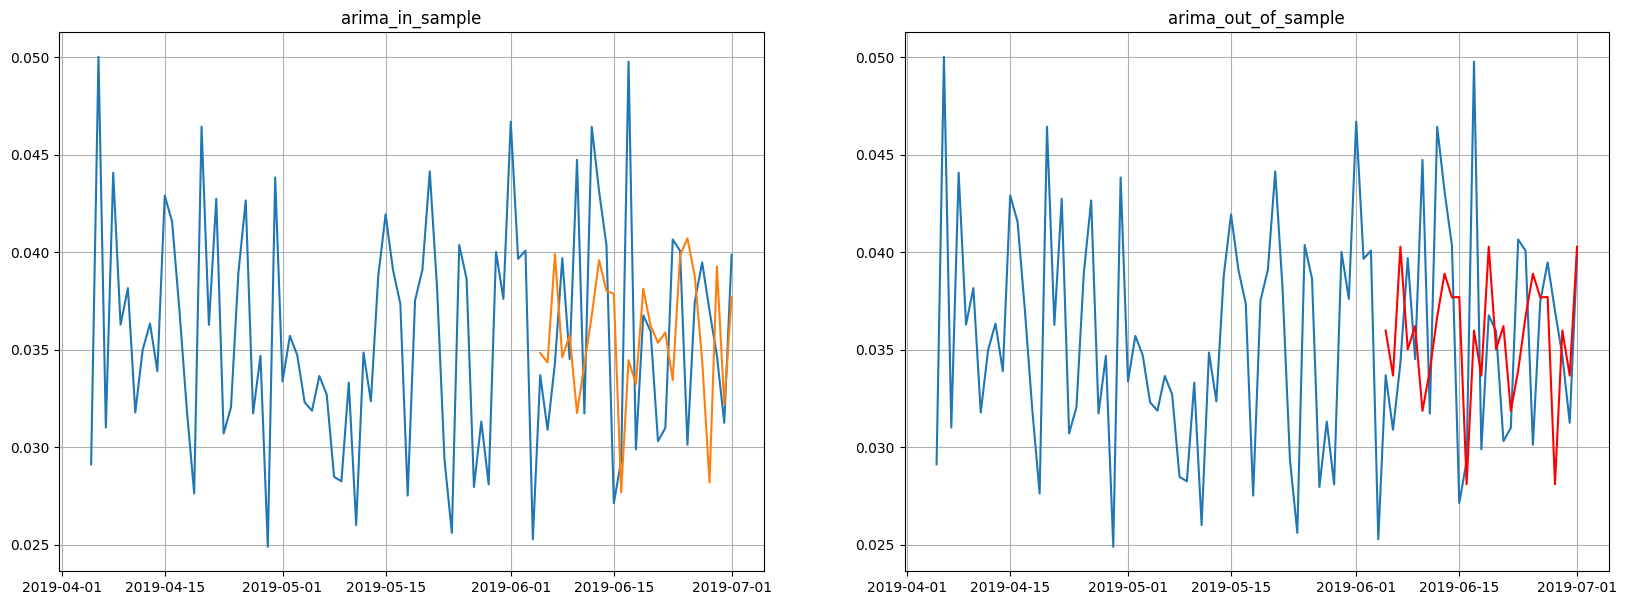

In [ ]:
arima_full = forecast_ts_arima(full_noize,'full_noize','arima', param_grid = param_ar)


2019-06-26 12:00:00 2019-07-02 18:00:00
2019-06-26 12:00:00 2019-07-02 18:00:00
2019-06-26 12:00:00 2019-07-02 18:00:00
2019-06-26 12:00:00 2019-07-02 18:00:00
2019-06-26 12:00:00 2019-07-02 18:00:00
2019-06-26 12:00:00 2019-07-02 18:00:00


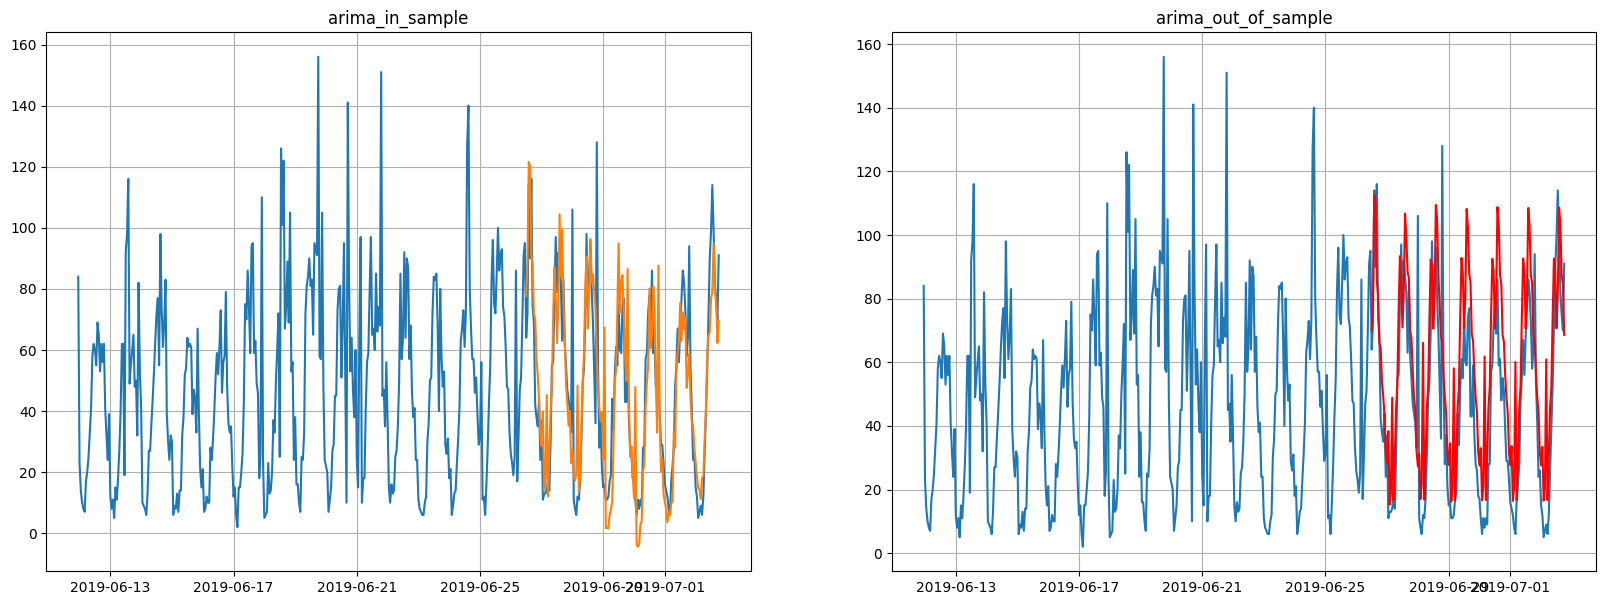

In [ ]:
arima_med = forecast_ts_arima(medium_noize,'medium_noize','arima', param_grid = param_ar)

2019-08-15 00:00:00 2019-11-29 00:00:00
2019-08-15 00:00:00 2019-11-29 00:00:00
2019-08-15 00:00:00 2019-11-29 00:00:00
2019-08-15 00:00:00 2019-11-29 00:00:00
2019-08-15 00:00:00 2019-11-29 00:00:00
2019-08-15 00:00:00 2019-11-29 00:00:00


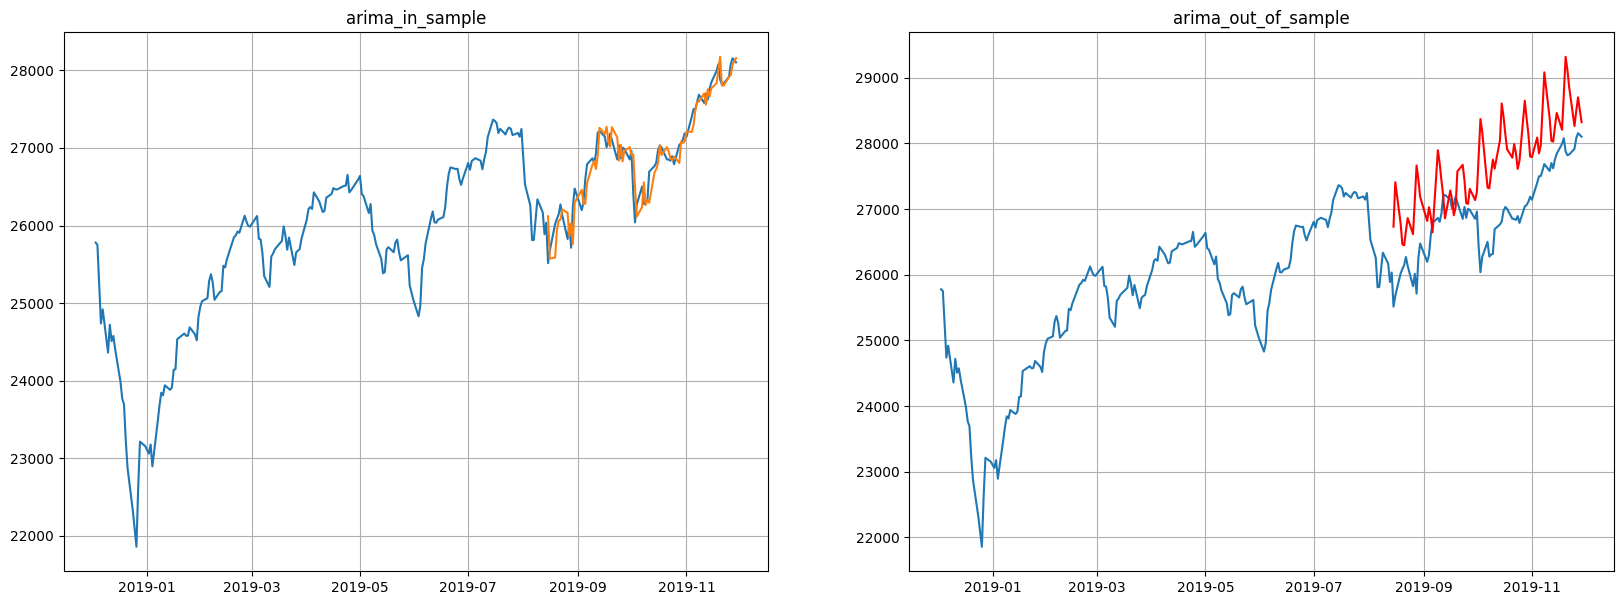

In [ ]:
arima_rand = forecast_ts_arima(random_walk,'random_walk','arima', param_grid = param_ar)

1988-01-01 00:00:00 1990-12-31 00:00:00
1988-01-01 00:00:00 1990-12-31 00:00:00
1988-01-01 00:00:00 1990-12-31 00:00:00
1988-01-01 00:00:00 1990-12-31 00:00:00


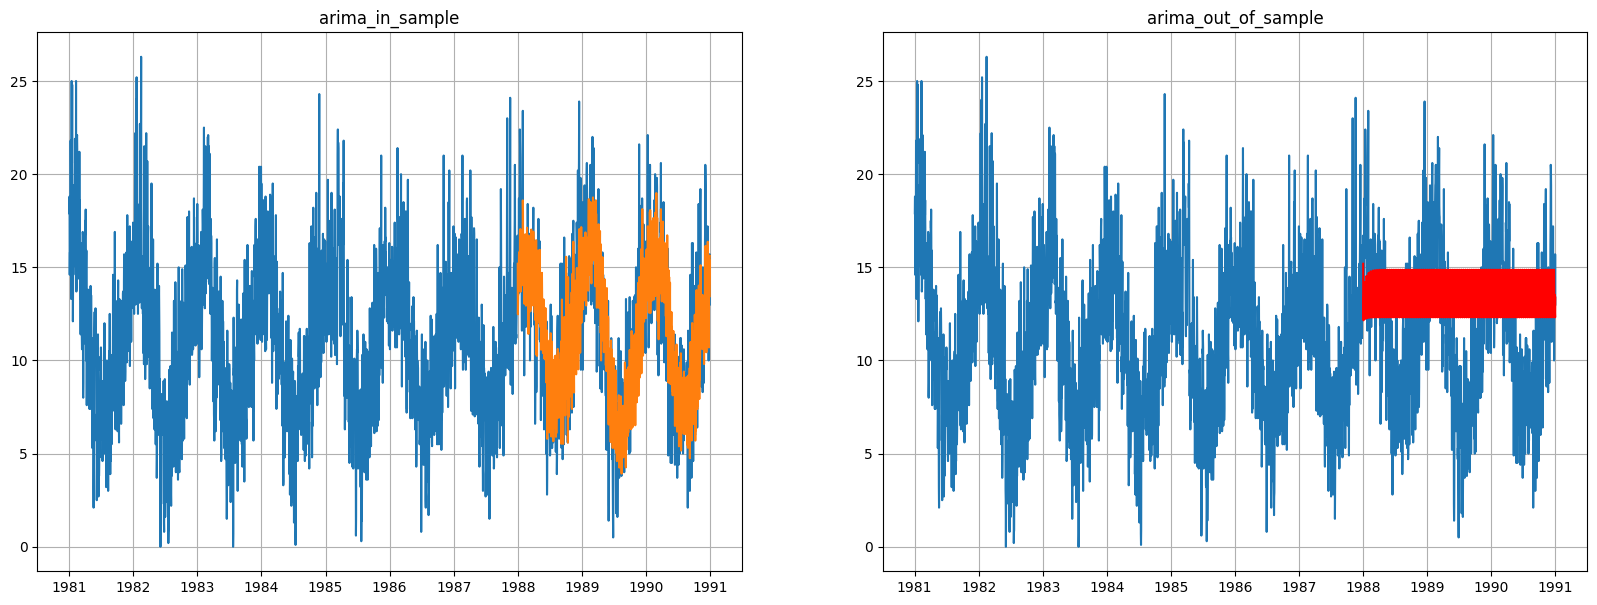

In [ ]:
param_ar= {'d':[0,1]}
arima_long = forecast_ts_arima(long,'long','arima', param_grid = param_ar)

In [ ]:
result = pd.concat([arima_short,arima_rand,arima_med,arima_full,arima_s_tr, arima_long,long_df,sh_tr, full, medium,short_df, rand ]).\
sort_values(by = ['R2'], ascending=False)

In [ ]:
def filter_result(df:pd.DataFrame, ts_name = None,model= None,filter:str = 'tsa' , metrics = 'mse'):
  all = ['tsa','model','all']
  if filter not in all:
    raise ValueError('Введен неверный фильтр')

  if filter == 'tsa':
    result = df.melt(['tsa','model','type'], var_name = 'metric').\
    pivot_table(index = ['tsa','model','type'],columns=['metric'], values='value', aggfunc='min').loc[ts_name].sort_values([metrics])

  if filter == 'model':
    if model == None:
      raise ValueError('Введите модель для фильтра')
    result = df.melt(['tsa','model','type'], var_name = 'metric').\
    pivot_table(index = ['tsa','model','type'],columns=['metric'], values='value', aggfunc='min').loc[:,model,:].sort_values(['R2'])

  if filter == 'all':
    result = df.melt(['tsa','model','type'], var_name = 'metric').\
    pivot_table(index = ['tsa','model','type'],columns=['metric'], values='value', aggfunc='min')

  return result

In [ ]:
filter_result(result, filter = 'model', model = 'Ridge')

metric                                  R2          mae      mape       mase  \
tsa                type                                                        
random_walk        out_of_sample -7.050228  1589.038187  0.058275  38.851407   
full_noize         in_sample     -0.068166     0.004619  0.126056  18.651024   
                   out_of_sample -0.068147     0.004619  0.126059  18.663956   
long               out_of_sample  0.546062     2.102578  0.230160  18.766899   
short_season       out_of_sample  0.570914    30.003012  2.163934   2.273596   
short_season_trend out_of_sample  0.641616    40.678737  0.096185   1.000366   
long               in_sample      0.682916     1.782890  0.194902   1.519674   
medium_noize       in_sample      0.738493    10.167095  0.306976   1.484747   
                   out_of_sample  0.743275    10.348144  0.337079   1.738712   
short_season       in_sample      0.842456    15.030304  0.969513   0.803982   
random_walk        in_sample      0.852260   207.646687  0.007723   1.063454   
short_season_trend in_sample      0.964033    11.737685  0.028305   0.281700   

metric                                     mse      smape  
tsa                type                                    
random_walk        out_of_sample  60384.000000   6.054913  
full_noize         in_sample          0.000034  12.674177  
                   out_of_sample      0.000000  12.674323  
long               out_of_sample      5.000000  19.902045  
short_season       out_of_sample    500.000000  59.317557  
short_season_trend out_of_sample    211.000000   9.080091  
long               in_sample          5.059231  17.224095  
medium_noize       in_sample        234.065493  26.025273  
                   out_of_sample    234.000000  26.180735  
short_season       in_sample        500.039160  40.075021  
random_walk        in_sample      60384.764581   0.774943  
short_season_trend in_sample        211.343478   2.792079

ё### Задание 6. "Прогоните" все алгоритмы на всех рядах и получите сводную таблицу результатов по всем метрикам, постройте также графики прогнозов.